GitHub repository that we used for the API call functions:
    
   #### Wurzbacher, M. (2023). FAIR Checker evaluation. In FAIRness assessment tools evaluation using ORKG. GitHub. https://github.com/mwurzbacher/FAIRness-assessment-tools-evaluation-using-ORKG/blob/main/FAIR_Checker_evaluation.ipynb


### Importing the neccessary packages

In [5]:
import requests
import re
import json
import pandas as pd
import numpy as np
import matplotlib.lines as mlines
from itertools import chain
from matplotlib import pyplot as plt
import os

 Defining the neccessary functions for the assessment

In [2]:
# Making the get request to the Fair-Checker API that includes checking for all available metrics
# If the call is successful it stores the result and status code 200, else it stores None and 504
def get_all_metrics (payload):
    global count
    print(count)
    FAIR_checker_api = "https://fair-checker.france-bioinformatique.fr/api/check/metrics_all"
    try:
        response = requests.get(FAIR_checker_api, params=payload)
        print(payload)
        print(response.status_code)
        print("________________")
        count += 1
        return response.json(), response.status_code
    except:
        status = 504
        print(payload)
        print(status)
        print("________________")
        return None, status
    
    
# Transforms the result from the API call into a JSON dictionary   
def build_assessment_json(assessment):
    regex_result = re.findall("'metric': '.*?', 'score': '.*?'", assessment)
    assessment_list = []
    for result in regex_result:
        result = result.replace("\'", "\"")
        assessment_dict = json.loads("{"+result+"}")
        assessment_list.append(assessment_dict)
    return assessment_list

# Prints the most basic summary statistics about the 'Score' column
def print_summary_stats(df):
    print("Mean: " + str(df["Score"].mean()))
    print("Median: " + str(df["Score"].median()))
    print("Max: " + str(df["Score"].max()))
    print("Min: " + str(df["Score"].min()))

In [6]:
path = r"C:\Users\MolnarM\OneDrive - BDO Austria\Desktop\DSAI2"

os.chdir(path)

In [ ]:
input_file_path = r"./ogdmetadatendatagvat.csv"
output_file_path = r"./ogdmetadatendatagvat_cleaned.csv"

# Read the content of the file
with open(input_file_path, 'r') as file:
    content = file.read()

# Replace backslashes with forward slashes
modified_content = content.replace("\\", "/")

# Write the modified content back to a new file
with open(output_file_path, 'w') as file:
    file.write(modified_content)

### Importing the "cleaned" file, removing the first redundant rows

In [ ]:
df = pd.read_csv(r"./ogdmetadatendatagvat_cleaned.csv", encoding= 'unicode_escape', sep=';', on_bad_lines='skip', header=5, skiprows=[6,7])
df.head(10)

In [ ]:
#defining the date (its performed on)

date = "2024-05-14"

### Running the assesment loop for Austria

In [ ]:
count = 0
assessment_results = df['metadata_identifier'].map(lambda x: get_all_metrics(payload={'url': 'https://www.data.gv.at/katalog/dataset/' + x}))
df['FAIR_assessment'] = [aresult[0] for aresult in assessment_results]
df['assessment_status_code'] = [aresult[1] for aresult in assessment_results]
df.to_csv(r"./ogdmetadatendatagvat_assessed_"+date+".csv", encoding='utf-8')
df

### Modified code to include saving after every 100 assessed file as we were losing the results because some issues that broke the loop

In [ ]:
import pandas as pd
import requests
import time

# Keeping track of the progress
count = 0

def get_all_metrics(payload):
    global count
    print(count)
    FAIR_checker_api = "https://fair-checker.france-bioinformatique.fr/api/check/metrics_all"
    try:
        response = requests.get(FAIR_checker_api, params=payload)
        print(payload)
        print(response.status_code)
        print("________________")
        count += 1
        return response.json(), response.status_code
    except:
        status = 504
        print(payload)
        print(status)
        print("________________")
        return None, status

def assess_and_save(df, save_interval=100, save_path=r"./ogdmetadatendatagvat_assessed_intermediate.csv"):
    # Initialize columns with None
    df['FAIR_assessment'] = None
    df['assessment_status_code'] = None

    for index, x in df['metadata_identifier'].iteritems():
        if pd.notna(x):
            result = get_all_metrics(payload={'url': 'https://www.data.gv.at/katalog/dataset/' + str(x)})
        else:
            result = (None, None)
        
        # Update the DataFrame with the result
        df.at[index, 'FAIR_assessment'] = result[0]
        df.at[index, 'assessment_status_code'] = result[1]
        
        # Save intermediate results
        if (index + 1) % save_interval == 0:
            df.to_csv(save_path, encoding='utf-8', index=False)
            print(f"Saved intermediate results at index {index + 1}")
            time.sleep(1)  # To avoid hitting API rate limits or overloading the server
    
    return df

# Perform the assessment and save intermediate results
df = assess_and_save(df)

# Save the final results
date = "20230527"  # Replace with your desired date string
output_path = r"./ogdmetadatendatagvat_assessed_" + date + ".csv"
df.to_csv(output_path, encoding='utf-8', index=False)


In [3]:
# Saving the results as an excel file as well
df = pd.read_excel(r"./assessed_excel.xlsx")

In [10]:
# Only keeping successful assessments
df = df[df["assessment_status_code"] == 200]
df = df.drop(labels=["assessment_status_code"], axis=1).reset_index(drop=True)
# Transforming the results to JSON dicts
df["FAIR_assessment"] = df["FAIR_assessment"].map(lambda x: build_assessment_json(x))
df

Unnamed: 0  local_id                   metadata_identifier  \
0               0         1  3E7BDC0B-6CBC-5A25-AF07-409E1EA40408   
1               1         2  d7e2c489-c233-4458-9d98-a2048a73a43e   
2               2         3  03986e54-6367-41aa-bcba-8c51036237dc   
3               3         4  3e54878c-8657-4268-ad6e-064c3869169e   
4               4         5  0718837e-ffba-4833-b38f-a56b8ce0c012   
...           ...       ...                                   ...   
14132       14144     14145  3fe4b483-0a4f-4dab-94ed-076fe22b770b   
14133       14145     14146  f21ab3d9-ba40-461f-9576-52285a030a31   
14134       14146     14147  36aa0889-39cd-4d4b-b17b-130e53af4c4a   
14135       14147     14148  05269861-a62f-4b95-8bc1-43a778984208   
14136       14148     14149  36cbb257-de7d-484a-80e2-209177977117   

      metadata_modified                                              Title  \
0            2023-07-03  Entwicklung nachhaltiger Schilferntetechniken ...   
1            2023-07-02             Voranschlag Kohfidisch 2023 (Gemeinde)   
2            2023-07-02      Rechnungsabschluss Kohfidisch 2022 (Gemeinde)   
3            2023-07-02  Rechnungsabschluss Kohfidisch 2021 (Statistik ...   
4            2023-07-02  Rechnungsabschluss Kohfidisch 2020 (Statistik ...   
...                 ...                                                ...   
14132        2022-01-10                Voranschlag Pöndorf 2021 (Gemeinde)   
14133        2022-01-10         Rechnungsabschluss Pöndorf 2020 (Gemeinde)   
14134        2022-01-10      Rechnungsabschluss Mauthausen 2020 (Gemeinde)   
14135        2022-01-10  Rechnungsabschluss Purgstall an der Erlauf 202...   
14136        2022-01-10   Voranschlag Aschach an der Steyr 2021 (Gemeinde)   

                                             description  \
0                                                    NaN   
1      Voranschlag der Gemeinde - Einnahmen und Ausgaben   
2      Rechnungsabschluss der Gemeinde - Einnahmen un...   
3      Rechnungsabschluss der Gemeinde - Einnahmen un...   
4      Rechnungsabschluss der Gemeinde - Einnahmen un...   
...                                                  ...   
14132  Voranschlag der Gemeinde - Einnahmen und Ausgaben   
14133  Rechnungsabschluss der Gemeinde - Einnahmen un...   
14134  Rechnungsabschluss der Gemeinde - Einnahmen un...   
14135  Rechnungsabschluss der Gemeinde - Einnahmen un...   
14136  Voranschlag der Gemeinde - Einnahmen und Ausgaben   

                categorization  \
0                       Umwelt   
1      Wirtschaft und Finanzen   
2      Wirtschaft und Finanzen   
3      Wirtschaft und Finanzen   
4      Wirtschaft und Finanzen   
...                        ...   
14132  Wirtschaft und Finanzen   
14133  Wirtschaft und Finanzen   
14134  Wirtschaft und Finanzen   
14135  Wirtschaft und Finanzen   
14136  Wirtschaft und Finanzen   

                                                    tags  \
0      Nationalparks Austria, Naturschutz, OpenDocume...   
1      Ausgaben, Budget, Einnahmen, Ergebnishaushalt,...   
2      Ausgaben, Budget, Einnahmen, Ergebnishaushalt,...   
3      Ausgaben, Budget, Einnahmen, Ergebnishaushalt,...   
4      Ausgaben, Budget, Einnahmen, Ergebnishaushalt,...   
...                                                  ...   
14132  Ausgaben, Budget, Einnahmen, Ergebnishaushalt,...   
14133  Ausgaben, Budget, Einnahmen, Ergebnishaushalt,...   
14134  Ausgaben, Budget, Einnahmen, Ergebnishaushalt,...   
14135  Ausgaben, Budget, Einnahmen, Ergebnishaushalt,...   
14136  Ausgaben, Budget, Einnahmen, Ergebnishaushalt,...   

                          maintainer  \
0      NP Neusiedler See - Seewinkel   
1                   10908 Kohfidisch   
2                   10908 Kohfidisch   
3                   10908 Kohfidisch   
4                   10908 Kohfidisch   
...                              ...   
14132                  41726 Pöndorf   
14133                  41726 Pöndorf   
14134               41111 Maut

In [14]:
# Converting the metrics to a dictionary and creating a seperate df out of it
def convert_metrics_to_dict(metric_list):
    return {d['metric']: d['score'] for d in metric_list}

# Apply the function to the 'metrics' column
metrics_dicts = df['FAIR_assessment'].apply(convert_metrics_to_dict)

# Create a new DataFrame from the list of dictionaries
metrics_df = pd.DataFrame(metrics_dicts.tolist())


metrics_df

F1A F1B F2A F2B A1.1 A1.2 I1 I2 I3 R1.1 R1.2 R1.3
0       2   0   1   1    2    2  1  1  0    2    2    1
1       2   0   1   1    2    2  1  1  0    2    2    1
2       2   0   1   1    2    2  1  1  0    2    2    1
3       2   0   1   1    2    2  1  1  0    2    2    1
4       2   0   1   1    2    2  1  1  0    2    2    1
...    ..  ..  ..  ..  ...  ... .. .. ..  ...  ...  ...
14132   2   0   1   1    2    2  1  1  0    2    2    1
14133   2   0   1   1    2    2  1  1  0    2    2    1
14134   2   0   1   1    2    2  1  1  0    2    2    1
14135   2   0   1   1    2    2  1  1  0    2    2    1
14136   2   0   1   1    2    2  1  1  0    2    2    1

[14137 rows x 12 columns]

In [16]:
# Combining the metadata information and the table that contains the scores for the metrics
df_combined = pd.concat([df, metrics_df], axis=1, ignore_index=True)
df_combined = df_combined.drop(columns = [0,1])

df_combined.columns

In [41]:
df_combined.loc[:, 33:]

33 34 35 36 37 38 39 40 41 42 43 44
0      2  0  1  1  2  2  1  1  0  2  2  1
1      2  0  1  1  2  2  1  1  0  2  2  1
2      2  0  1  1  2  2  1  1  0  2  2  1
3      2  0  1  1  2  2  1  1  0  2  2  1
4      2  0  1  1  2  2  1  1  0  2  2  1
...   .. .. .. .. .. .. .. .. .. .. .. ..
14132  2  0  1  1  2  2  1  1  0  2  2  1
14133  2  0  1  1  2  2  1  1  0  2  2  1
14134  2  0  1  1  2  2  1  1  0  2  2  1
14135  2  0  1  1  2  2  1  1  0  2  2  1
14136  2  0  1  1  2  2  1  1  0  2  2  1

[14137 rows x 12 columns]

In [45]:
columns = df_combined.columns

In [47]:
# Lost the column names in the meantime so renaming them so we now which column corresponds to which metric
new_column_names = ['F1A', 'F1B', 'F2A', 'F2B', 'A1.1','A1.2', 'I1', 'I2', 'I3', 'R1.1', 'R1.2', 'R1.3']

# Renaming the last 12 columns - the ones containing the metrics
df_combined.rename(columns=dict(zip(columns[-12:], new_column_names)), inplace=True)

print(df_combined.head())

                                      2           3  \
0  3E7BDC0B-6CBC-5A25-AF07-409E1EA40408  2023-07-03   
1  d7e2c489-c233-4458-9d98-a2048a73a43e  2023-07-02   
2  03986e54-6367-41aa-bcba-8c51036237dc  2023-07-02   
3  3e54878c-8657-4268-ad6e-064c3869169e  2023-07-02   
4  0718837e-ffba-4833-b38f-a56b8ce0c012  2023-07-02   

                                                   4  \
0  Entwicklung nachhaltiger Schilferntetechniken ...   
1             Voranschlag Kohfidisch 2023 (Gemeinde)   
2      Rechnungsabschluss Kohfidisch 2022 (Gemeinde)   
3  Rechnungsabschluss Kohfidisch 2021 (Statistik ...   
4  Rechnungsabschluss Kohfidisch 2020 (Statistik ...   

                                                   5                        6  \
0                                                NaN                   Umwelt   
1  Voranschlag der Gemeinde - Einnahmen und Ausgaben  Wirtschaft und Finanzen   
2  Rechnungsabschluss der Gemeinde - Einnahmen un...  Wirtschaft und Finanzen   
3  Rechn

In [53]:
# Converting the metric columns to numerical
for col in new_column_names:
    df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce')
    
# Summing the last 12 columns row-wise and storing the result in a new column called 'Score'
df_combined['Score'] = df_combined[new_column_names].sum(axis=1)

In [59]:
# First look at the results
print_summary_stats(df_combined)

Mean: 14.021220909669662
Median: 15.0
Max: 19
Min: 0


In [62]:
# Removing the limit so all the columns are displayed 
pd.set_option('display.max_columns', None)

### Processing the files from the German data portal

In [5]:
df2 = pd.read_csv(r"./ogdmetadatendatagvat_assessed_german2024-06-10.csv", index_col = [0])

In [6]:
df2.head()

author           author_email  \
0    Hanse- und Universitätsstadt Rostock – Hauptamt  geodienste@rostock.de   
1  Hanse- und Universitätsstadt Rostock – Kataste...  geodienste@rostock.de   
2  Hanse- und Universitätsstadt Rostock – Kataste...  geodienste@rostock.de   
3  Hanse- und Universitätsstadt Rostock – Kataste...  geodienste@rostock.de   
4    Hanse- und Universitätsstadt Rostock – Hauptamt  geodienste@rostock.de   

                        creator_user_id                                    id  \
0  f512f73d-bed2-439d-8f6f-3fbc6048b24e  05be0aa5-76a2-4850-b37f-69e623565fbe   
1  f512f73d-bed2-439d-8f6f-3fbc6048b24e  44fa7d61-7924-4740-95ec-b4a6821139fe   
2  f512f73d-bed2-439d-8f6f-3fbc6048b24e  6219e4c3-e819-40f0-86cd-543ff829ad6c   
3  f512f73d-bed2-439d-8f6f-3fbc6048b24e  7c46a2cc-4fe3-4399-8833-61b016730b71   
4  f512f73d-bed2-439d-8f6f-3fbc6048b24e  4d25536c-7cc4-4761-8504-0ba8ca320fa1   

   isopen  license_id  license_title  \
0   False         NaN            NaN   
1   False         NaN            NaN   
2   False         NaN            NaN   
3   False         NaN            NaN   
4   False         NaN            NaN   

                                          maintainer       maintainer_email  \
0  Hanse- und Universitätsstadt Rostock – Kataste...  geodienste@rostock.de   
1  Hanse- und Universitätsstadt Rostock – Kataste...  geodienste@rostock.de   
2  Hanse- und Universitätsstadt Rostock – Kataste...  geodienste@rostock.de   
3  Hanse- und Universitätsstadt Rostock – Kataste...  geodienste@rostock.de   
4  Hanse- und Universitätsstadt Rostock – Kataste...  geodienste@rostock.de   

             metadata_created  ...  \
0  2023-01-06T06:14:11.920576  ...   
1  2024-05-08T06:31:53.940777  ...   
2  2024-05-08T06:31:46.141017  ...   
3  2024-05-08T06:32:00.483952  ...   
4  2024-05-08T06:32:18.276436  ...   

                                                 url version  \
0  https://www.opendata-hro.de/dataset/e7c10dd4-d...     NaN   
1  https://www.opendata-hro.de/dataset/c276228b-9...     NaN   
2  https://www.opendata-hro.de/dataset/655f46c2-1...     NaN   
3  https://www.opendata-hro.de/dataset/7afdfa7a-7...     NaN   
4  https://www.opendata-hro.de/dataset/aceccfc0-d...     NaN   

                                              extras  \
0  [{'key': 'access_rights', 'value': 'http://pub...   
1  [{'key': 'access_rights', 'value': 'http://pub...   
2  [{'key': 'access_rights', 'value': 'http://pub...   
3  [{'key': 'access_rights', 'value': 'http://pub...   
4  [{'key': 'access_rights', 'value': 'http://pub...   

                                              groups  \
0  [{'description': '', 'display_name': 'Regierun...   
1  [{'description': '', 'display_name': 'Regierun...   
2  [{'description': '', 'display_name': 'Regierun...   
3  [{'description': '', 'display_name': 'Bildung,...   
4  [{'description': '', 'display_name': 'Regierun...   

                                           resources  \
0  [{'access_url': 'https://geo.sv.rostock.de/dow...   
1  [{'access_url': 'https://geo.sv.rostock.de/dow...   
2  [{'access_url': 'https://geo.sv.rostock.de/dow...   
3  [{'access_url': 'https://geo.sv.rostock.de/dow...   
4  [{'access_url': 'https://geo.sv.rostock.de/dow...   

                                                tags relationships_as_subject  \
0  [{'display_name': 'politik', 'id': 'a8e6e4aa-6...                       []   
1  [{'display_name': 'bauleitplanung', 'id': '861...                       []   
2  [{'display_name': 'bauleitplanung', 'id': '861...                       []   
3  [{'display_name': 'freizeit', 'id': '73a5f345-...                       []   
4  [{'display_name': 'behörde', 'id': 'e15183d8-d...                       []   

   relationships_as_object                                    FAIR_assessment  \
0                       []  [{'metric': 'F1A', 'score': '2', 'target_uri':...   
1                       []  [{'metric': 'F1A', 'score': '2', 'target_uri':...   
2            

In [7]:
df2 = df2[df2["assessment_status_code"] == 200]
df2 = df2.drop(labels=["assessment_status_code"], axis=1).reset_index(drop=True)
df2["FAIR_assessment"] = df2["FAIR_assessment"].map(lambda x: build_assessment_json(x))
df2

author  \
0       Hanse- und Universitätsstadt Rostock – Hauptamt   
1     Hanse- und Universitätsstadt Rostock – Kataste...   
2     Hanse- und Universitätsstadt Rostock – Kataste...   
3     Hanse- und Universitätsstadt Rostock – Kataste...   
4       Hanse- und Universitätsstadt Rostock – Hauptamt   
...                                                 ...   
9069                                                NaN   
9070                                                NaN   
9071                                                NaN   
9072                                                NaN   
9073                                                NaN   

               author_email                       creator_user_id  \
0     geodienste@rostock.de  f512f73d-bed2-439d-8f6f-3fbc6048b24e   
1     geodienste@rostock.de  f512f73d-bed2-439d-8f6f-3fbc6048b24e   
2     geodienste@rostock.de  f512f73d-bed2-439d-8f6f-3fbc6048b24e   
3     geodienste@rostock.de  f512f73d-bed2-439d-8f6f-3fbc6048b24e   
4     geodienste@rostock.de  f512f73d-bed2-439d-8f6f-3fbc6048b24e   
...                     ...                                   ...   
9069                    NaN  f512f73d-bed2-439d-8f6f-3fbc6048b24e   
9070                    NaN  f512f73d-bed2-439d-8f6f-3fbc6048b24e   
9071                    NaN  f512f73d-bed2-439d-8f6f-3fbc6048b24e   
9072                    NaN  f512f73d-bed2-439d-8f6f-3fbc6048b24e   
9073                    NaN  f512f73d-bed2-439d-8f6f-3fbc6048b24e   

                                        id  isopen  license_id  license_title  \
0     05be0aa5-76a2-4850-b37f-69e623565fbe   False         NaN            NaN   
1     44fa7d61-7924-4740-95ec-b4a6821139fe   False         NaN            NaN   
2     6219e4c3-e819-40f0-86cd-543ff829ad6c   False         NaN            NaN   
3     7c46a2cc-4fe3-4399-8833-61b016730b71   False         NaN            NaN   
4     4d25536c-7cc4-4761-8504-0ba8ca320fa1   False         NaN            NaN   
...                                    ...     ...         ...            ...   
9069  bed1ad07-1963-4175-bb73-0af79479eede   False         NaN            NaN   
9070  80c44751-ed80-4433-99f5-4baf108e1155   False         NaN            NaN   
9071  daaf2c24-652d-474b-a9ae-aad1ec9a3a6c   False         NaN            NaN   
9072  092f7b48-66bd-465d-ab94-49c237470fdf   False         NaN            NaN   
9073  2444f126-3d4a-4421-8d40-a8ddc4b73a7a   False         NaN            NaN   

                                             maintainer  \
0     Hanse- und Universitätsstadt Rostock – Kataste...   
1     Hanse- und Universitätsstadt Rostock – Kataste...   
2     Hanse- und Universitätsstadt Rostock – Kataste...   
3     Hanse- und Universitätsstadt Rostock – Kataste...   
4     Hanse- und Universitätsstadt Rostock – Kataste...   
...                                                 ...   
9069                                                NaN   
9070                                                NaN   
9071                                                NaN   
9072                                                NaN   
9073                                                NaN   

           maintainer_email            metadata_created  ...     type  \
0     geodienste@rostock.de  2023-01-06T06:14:11.920576  ...  dataset   
1     geodienste@rostock.de  2024-05-08T06:31:53.940777  ...  dataset   
2     geodienste@rostock.de  2024-05-08T06:31:46.141017  ...  dataset   
3     geodienste@rostock.de  2024-05-08T06:32:00.483952  ...  dataset   
4     geodienste@rostock.de  2024-05-08T06:32:18.276436  ...  dataset   
...                     ...                         ...  ...      ...   
9069                    NaN  2021-06-02T11:24:14.680308  ...  dataset   
9070                    NaN  2021-06-02T11:21:15.752075  ...  dataset   
9071                    NaN  2024-01-05T08:52:48.735472  ...  dataset   
9072                    NaN  2018-07-27T08:08:07.793153  ...  dataset   
9073                    Na

In [10]:
metrics_dicts = df2['FAIR_assessment'].apply(convert_metrics_to_dict)

# Create a new DataFrame from the list of dictionaries
metrics_df2 = pd.DataFrame(metrics_dicts.tolist())

df_combined2 = pd.concat([df2, metrics_df2], axis=1, ignore_index=True)


columns = df_combined2.columns

new_column_names = ['F1A', 'F1B', 'F2A', 'F2B', 'A1.1','A1.2', 'I1', 'I2', 'I3', 'R1.1', 'R1.2', 'R1.3']

# Renaming the last 12 columns
df_combined2.rename(columns=dict(zip(columns[-12:], new_column_names)), inplace=True)

for col in new_column_names:
    df_combined2[col] = pd.to_numeric(df_combined2[col], errors='coerce')
    
    
df_combined2['Score'] = df_combined2[new_column_names].sum(axis=1)

print_summary_stats(df_combined2)

Mean: 6.320255675556536
Median: 5.0
Max: 16
Min: 0


### Files from the Swiss data portal

In [12]:
df3 = pd.read_csv(r"./ogdmetadatendatagvat_assessed_swiss2024-06-12.csv", index_col = [0])

In [14]:
df3 = df3[df3["assessment_status_code"] == 200]
df3 = df3.drop(labels=["assessment_status_code"], axis=1).reset_index(drop=True)
df3["FAIR_assessment"] = df3["FAIR_assessment"].map(lambda x: build_assessment_json(x))
df3

Unnamed: 0                             owner_org  \
0               0  b3d5c5d8-f736-459e-b23b-fe0ea6196cf2   
1              25  1e4cc1ec-05f2-4801-821e-492a8199dced   
2              26  1e4cc1ec-05f2-4801-821e-492a8199dced   
3              27  1e4cc1ec-05f2-4801-821e-492a8199dced   
4              29  51ffc9d5-bf18-4bb4-9b26-ad9b45a60e14   
...           ...                                   ...   
10253       11886  1e4cc1ec-05f2-4801-821e-492a8199dced   
10254       11887  1e4cc1ec-05f2-4801-821e-492a8199dced   
10255       11888  1e4cc1ec-05f2-4801-821e-492a8199dced   
10256       11889  1e4cc1ec-05f2-4801-821e-492a8199dced   
10257       11890  1e4cc1ec-05f2-4801-821e-492a8199dced   

                                              maintainer  \
0                                          Sara Schärrer   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4      Stadt Winterthur, Stadtentwicklung der Stadt W...   
...                                                  ...   
10253                                                NaN   
10254                                                NaN   
10255                                                NaN   
10256                                                NaN   
10257                                                NaN   

                          issued  \
0            2023-03-02T00:00:00   
1            2023-08-30T00:00:00   
2            2024-06-06T00:00:00   
3            2024-01-31T00:00:00   
4      2022-09-20T17:10:34+01:00   
...                          ...   
10253        2023-02-08T00:00:00   
10254        2023-01-18T00:00:00   
10255        2023-03-01T00:00:00   
10256        2023-02-08T00:00:00   
10257        2023-03-01T00:00:00   

                                          title_for_slug qualified_relations  \
0                    Tierseuchenmeldungen in der Schweiz                  []   
1      klimaanalyse-windgeschwindigkeit-nacht-zukunft...                  []   
2       gebaudeflachen-mit-adressen-amtliche-vermessung2                  []   
3                                       kantonsstrassen1                  []   
4      beschaftigtendichte-in-der-stadt-winterthur-ab...                  []   
...                                                  ...                 ...   
10253     gebaude-digitales-oberflachenmodell-lidar-2018                 NaN   
10254         administrative-einteilung-av-und-grundbuch                 NaN   
10255                                       strassenlarm                 NaN   
10256                                 orthofoto-2012-rgb                 NaN   
10257                                      waldwanderung                 NaN   

       private             maintainer_email  num_tags  \
0        False  sara.schaerrer@blv.admin.ch         9   
1        False                          NaN         0   
2        False                          NaN         0   
3        False                          NaN         0   
4        False             statistik@win.ch         4   
...        ...                          ...       ...   
10253    False                          NaN         0   
10254    False                          NaN         0   
10255    False                          NaN         0   
10256    False                          NaN         0   
10257    False                          NaN         0   

                                          contact_points  ...  \
0      [{'name': 'Kompetenzzentrum Daten', 'email': '...  ...   
1      [{'email': 'afu@bd.so.ch', 'name': 'afu@bd.so....  ...   
2      [{'email': 'agi@bd.so.ch', 'name': 'agi@bd.so....  ...   
3      [{'email': 'avt@bd.so.ch', 'name': 'avt@bd.so....  ...   
4      [{'email': 'statistik@win.ch', 'name': 'Stadt ...  ...   
...                                                  ...  ...   
10253  [{'email': 'agi@bd.so.ch', 'name': '

In [15]:
metrics_dicts = df3['FAIR_assessment'].apply(convert_metrics_to_dict)

# Create a new DataFrame from the list of dictionaries
metrics_df3 = pd.DataFrame(metrics_dicts.tolist())

df_combined3 = pd.concat([df3, metrics_df3], axis=1, ignore_index=True)


columns = df_combined3.columns

new_column_names = ['F1A', 'F1B', 'F2A', 'F2B', 'A1.1','A1.2', 'I1', 'I2', 'I3', 'R1.1', 'R1.2', 'R1.3']

# Renaming the last 12 columns
df_combined3.rename(columns=dict(zip(columns[-12:], new_column_names)), inplace=True)

for col in new_column_names:
    df_combined3[col] = pd.to_numeric(df_combined3[col], errors='coerce')
    
    
df_combined3['Score'] = df_combined3[new_column_names].sum(axis=1)



Mean: 6.320255675556536
Median: 5.0
Max: 16
Min: 0


### Files from the Irish data portal

In [27]:
df4 = pd.read_csv(r"./ogdmetadatendatagvat_assessed_irish2024-06-12.csv", index_col = [0])

In [28]:
len(df4)

15000

In [29]:
df4 = df4[df4["assessment_status_code"] == 200]
df4 = df4.drop(labels=["assessment_status_code"], axis=1).reset_index(drop=True)

In [32]:
# When running the same functions we encountered an issue with JSON formatting
# So we slightly modified the code such that it handles the error
def build_assessment_json2(assessment):
    regex_result = re.findall(r"'metric': '.*?', 'score': '.*?'", assessment)
    assessment_list = []
    for result in regex_result:
        result = result.replace("\'", "\"")  # Replace single quotes with double quotes
        json_string = "{" + result + "}"  # Construct the JSON string
        try:
            print(f"Parsing JSON string: {json_string}")  # Debug print statement
            assessment_dict = json.loads(json_string)  # Parse JSON string
            assessment_list.append(assessment_dict)  # Append to list
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON string: {json_string}")
            print(f"JSONDecodeError: {e}")
    return assessment_list

In [33]:
df4["FAIR_assessment"] = df4["FAIR_assessment"].map(lambda x: build_assessment_json2(x))

Parsing JSON string: {"metric": "F1A", "score": "2"}
Parsing JSON string: {"metric": "F1B", "score": "0"}
Parsing JSON string: {"metric": "F2A", "score": "0"}
Parsing JSON string: {"metric": "F2B", "score": "0"}
Parsing JSON string: {"metric": "A1.1", "score": "2"}
Parsing JSON string: {"metric": "A1.2", "score": "0"}
Parsing JSON string: {"metric": "I1", "score": "0"}
Parsing JSON string: {"metric": "I2", "score": "0"}
Parsing JSON string: {"metric": "I3", "score": "0"}
Parsing JSON string: {"metric": "R1.1", "score": "0"}
Parsing JSON string: {"metric": "R1.2", "score": "0"}
Parsing JSON string: {"metric": "R1.3", "score": "0"}
Parsing JSON string: {"metric": "F1A", "score": "2"}
Parsing JSON string: {"metric": "F1B", "score": "0"}
Parsing JSON string: {"metric": "F2A", "score": "1"}
Parsing JSON string: {"metric": "F2B", "score": "2"}
Parsing JSON string: {"metric": "A1.1", "score": "2"}
Parsing JSON string: {"metric": "A1.2", "score": "0"}
Parsing JSON string: {"metric": "I1", "sco

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [34]:
metrics_dicts = df4['FAIR_assessment'].apply(convert_metrics_to_dict)

# Create a new DataFrame from the list of dictionaries
metrics_df4 = pd.DataFrame(metrics_dicts.tolist())

df_combined4 = pd.concat([df4, metrics_df4], axis=1, ignore_index=True)


columns = df_combined4.columns

new_column_names = ['F1A', 'F1B', 'F2A', 'F2B', 'A1.1','A1.2', 'I1', 'I2', 'I3', 'R1.1', 'R1.2', 'R1.3']

# Renaming the last 12 columns
df_combined4.rename(columns=dict(zip(columns[-12:], new_column_names)), inplace=True)

for col in new_column_names:
    df_combined4[col] = pd.to_numeric(df_combined4[col], errors='coerce')
    
    
df_combined4['Score'] = df_combined4[new_column_names].sum(axis=1)

### Re-running the process on Austrian files with the exact same steps so the format of the results are identical

In [24]:
df = df[df["assessment_status_code"] == 200]
df = df.drop(labels=["assessment_status_code"], axis=1).reset_index(drop=True)
df["FAIR_assessment"] = df["FAIR_assessment"].map(lambda x: build_assessment_json(x))

In [25]:
metrics_dicts = df['FAIR_assessment'].apply(convert_metrics_to_dict)

# Create a new DataFrame from the list of dictionaries
metrics_df = pd.DataFrame(metrics_dicts.tolist())

df_combined = pd.concat([df, metrics_df], axis=1, ignore_index=True)


columns = df_combined.columns

new_column_names = ['F1A', 'F1B', 'F2A', 'F2B', 'A1.1','A1.2', 'I1', 'I2', 'I3', 'R1.1', 'R1.2', 'R1.3']

# Renaming the last 12 columns
df_combined.rename(columns=dict(zip(columns[-12:], new_column_names)), inplace=True)

for col in new_column_names:
    df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce')
    
    
df_combined['Score'] = df_combined[new_column_names].sum(axis=1)




In [35]:
print_summary_stats(df_combined)
print_summary_stats(df_combined2)
print_summary_stats(df_combined3)
print_summary_stats(df_combined4)

Mean: 14.021220909669662
Median: 15.0
Max: 19
Min: 0
Mean: 6.320255675556536
Median: 5.0
Max: 16
Min: 0
Mean: 9.01550009748489
Median: 9.0
Max: 24
Min: 0
Mean: 5.2843391902215435
Median: 4.0
Max: 22.0
Min: 0.0


In [84]:
import os
os.getcwd()

'C:\\Users\\MolnarM\\Desktop\\Notebooks\\Uni'

In [85]:
df.to_excel('austria_df.xlsx')
df2.to_excel('germany_df.xlsx')
df3.to_excel('switzerland_df.xlsx')
df4.to_excel('ireland_df.xlsx')

# Intermediate point

    - from here on the notebook can be run using the "country_df.xlsx" files, skipping the preprocessing and assessments

In [ ]:
df = pd.read_excel('austria_df.xlsx', index_col=0)
df2 = pd.read_excel('germany_df.xlsx', index_col=0)
df3 = pd.read_excel('switzerland_df.xlsx', index_col=0)
df4 = pd.read_excel('ireland_df.xlsx', index_col=0)

In [ ]:
new_column_names = ['F1A', 'F1B', 'F2A', 'F2B', 'A1.1','A1.2', 'I1', 'I2', 'I3', 'R1.1', 'R1.2', 'R1.3']

In [ ]:
metrics_dicts = df['FAIR_assessment'].apply(convert_metrics_to_dict)

# Create a new DataFrame from the list of dictionaries
metrics_df = pd.DataFrame(metrics_dicts.tolist())

df_combined = pd.concat([df, metrics_df], axis=1, ignore_index=True)


columns = df_combined.columns


# Renaming the last 12 columns
df_combined.rename(columns=dict(zip(columns[-12:], new_column_names)), inplace=True)

for col in new_column_names:
    df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce')


df_combined['Score'] = df_combined[new_column_names].sum(axis=1)

In [ ]:
metrics_dicts = df2['FAIR_assessment'].apply(convert_metrics_to_dict)

# Create a new DataFrame from the list of dictionaries
metrics_df2 = pd.DataFrame(metrics_dicts.tolist())

df_combined2 = pd.concat([df2, metrics_df2], axis=1, ignore_index=True)


columns = df_combined2.columns


# Renaming the last 12 columns
df_combined2.rename(columns=dict(zip(columns[-12:], new_column_names)), inplace=True)

for col in new_column_names:
    df_combined2[col] = pd.to_numeric(df_combined2[col], errors='coerce')
    
    
df_combined2['Score'] = df_combined2[new_column_names].sum(axis=1)


In [ ]:
metrics_dicts = df3['FAIR_assessment'].apply(convert_metrics_to_dict)

# Create a new DataFrame from the list of dictionaries
metrics_df3 = pd.DataFrame(metrics_dicts.tolist())

df_combined3 = pd.concat([df3, metrics_df3], axis=1, ignore_index=True)


columns = df_combined3.columns

# Renaming the last 12 columns
df_combined3.rename(columns=dict(zip(columns[-12:], new_column_names)), inplace=True)

for col in new_column_names:
    df_combined3[col] = pd.to_numeric(df_combined3[col], errors='coerce')
    
    
df_combined3['Score'] = df_combined3[new_column_names].sum(axis=1)

In [ ]:
metrics_dicts = df4['FAIR_assessment'].apply(convert_metrics_to_dict)

# Create a new DataFrame from the list of dictionaries
metrics_df4 = pd.DataFrame(metrics_dicts.tolist())

df_combined4 = pd.concat([df4, metrics_df4], axis=1, ignore_index=True)

columns = df_combined4.columns


# Renaming the last 12 columns
df_combined4.rename(columns=dict(zip(columns[-12:], new_column_names)), inplace=True)

for col in new_column_names:
    df_combined4[col] = pd.to_numeric(df_combined4[col], errors='coerce')
    
    
df_combined4['Score'] = df_combined4[new_column_names].sum(axis=1)

In [76]:
df_combined4.columns

Index([        0,         1,         2,         3,         4,         5,
               6,         7,         8,         9,        10,        11,
              12,        13,        14,        15,        16,        17,
              18,        19,        20,        21,        22,        23,
              24,        25,        26,        27,        28,        29,
              30,        31,        32,        33,        34,        35,
              36,        37,        38,        39,        40,        41,
              42,        43,        44,        45,        46,        47,
              48,        49,        50,        51,        52,        53,
              54,        55,        56,     'F1A',     'F1B',     'F2A',
           'F2B',    'A1.1',    'A1.2',      'I1',      'I2',      'I3',
          'R1.1',    'R1.2',    'R1.3',   'Score', 'Country'],
      dtype='object')

In [74]:
df_combined4

0             1  \
0                                  NaN           NaN   
1                                  NaN           NaN   
2                                  NaN           NaN   
3                                  NaN           NaN   
4                                  NaN           NaN   
...                                ...           ...   
13085                              NaN           NaN   
13086                              NaN           NaN   
13087  Environmental Protection Agency  AIRQD@epa.ie   
13088  Environmental Protection Agency  AIRQD@epa.ie   
13089  Environmental Protection Agency  AIRQD@epa.ie   

                                                       2  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                               swagger 2.0, Akoma Ntoso   
4                                                    NaN   
...                                                  ...   
13085                                                NaN   
13086                                                NaN   
13087  The INSPIRE Directive or INSPIRE lays down a g...   
13088  The INSPIRE Directive or INSPIRE lays down a g...   
13089  The INSPIRE Directive or INSPIRE lays down a g...   

                             3                          4             5  \
0                          NaN                        NaN           NaN   
1           opendata@tailte.ie                        NaN           NaN   
2              opendata@met.ie              Kieran Harper           NaN   
3      open.data@oireachtas.ie  Open Data Liaison Officer  (01) 6183000   
4                          NaN                        NaN           NaN   
...                        ...                        ...           ...   
13085                      NaN                        NaN           NaN   
13086                      NaN                        NaN           NaN   
13087                      NaN                        NaN           NaN   
13088                      NaN                        NaN           NaN   
13089                      NaN                        NaN           NaN   

                                          6                     7  \
0      0863c6bf-d7d8-485b-94b7-d50a11d5796d            Continuous   
1      f98da442-3307-463d-b676-a327e93755ec            Continuous   
2      f1eafd65-adc1-4721-aefc-fa9b6c9b3a0c            Continuous   
3      ef08264c-676d-48c5-aaad-6ce8aa18d521  Continuously updated   
4      ef08264c-676d-48c5-aaad-6ce8aa18d521                Weekly   
...                                     ...                   ...   
13085  4bb8ac75-49de-49b1-8568-ea7ba09886f8                   NaN   
13086  4bb8ac75-49de-49b1-8568-ea7ba09886f8                   NaN   
13087  ef08264c-676d-48c5-aaad-6ce8aa18d521                 Other   
13088  ef08264c-676d-48c5-aaad-6ce8aa18d521                 Other   
13089  ef08264c-676d-48c5-aaad-6ce8aa18d521                 Other   

                                          8     9  ... A1.1 A1.2 I1 I2 I3  \
0      f2d3c4fc-0ea7-4959-98c5-598241a5ea51  True  ...  2.0    0  0  0  0   
1      6eccd685-3dec-481b-9b9f-3f957ba9ddcd  True  ...  2.0    0  1  2  0   
2      0a8b1aa8-f49b-411e-a120-b0cd0297c2a1  True  ...  2.0    0  1  2  0   
3      d9ddc7ee-d497-41bb-924f-3557cfa12037  True  ...  2.0    0  0  0  0   
4      18020dbe-8565-47d0-8632-a8fc4dc540a0  True  ...  2.0    0  0  0  0   
...                                     ...   ...  ...  ...  ... .. .. ..   
13085  bc4dc2d9-1c0b-421a-98e0-b4b555402168  True  ...  2.0    0  1  2  0   
13086  7a1b5db7-ae22-4169-8aa8-19814f32514b  True  ...  2.0    0  1  2  0   
13087  2089f142-1f00-4526-9728-ea81fcecc8f9  True  ...  2.0    0  0  0  0   
13088  2803f489-ce32-4543-98ff-d14084b5f1bb  True  ...  2.0    0  0  0  0   
13089  f7cf61c6-c708-4529-bcce-dc331a630c1c  True  ...  2.0    0  

In [38]:
# Adding a country column so that it can be used for filtering/grouping
df_combined['Country'] = 'Austria'
#df_combined.head()
df_combined2['Country'] = 'Germany'
df_combined3['Country'] = 'Switzerland'
df_combined4['Country'] = 'Ireland'

In [46]:
# The metadata columns are slightly different for each country, only the metrics are identical
# Creating a dataframe that only contains the scores for the metrics (and score and country)
subset_df1 = df_combined.iloc[:, -14:]
subset_df2 = df_combined2.iloc[:, -14:]
subset_df3 = df_combined3.iloc[:, -14:]
subset_df4 = df_combined4.iloc[:, -14:]

# Concatenate the subsets into one big DataFrame
combined_df = pd.concat([subset_df1, subset_df2, subset_df3, subset_df4], axis=0)

# Reset the index to ensure it is unique
combined_df.reset_index(drop=True, inplace=True)


In [47]:
combined_df

F1A  F1B  F2A  F2B  A1.1  A1.2  I1  I2  I3  R1.1  R1.2  R1.3  Score  \
0        2    0    1  1.0   2.0     2   1   1   0     2     2     1   15.0   
1        2    0    1  1.0   2.0     2   1   1   0     2     2     1   15.0   
2        2    0    1  1.0   2.0     2   1   1   0     2     2     1   15.0   
3        2    0    1  1.0   2.0     2   1   1   0     2     2     1   15.0   
4        2    0    1  1.0   2.0     2   1   1   0     2     2     1   15.0   
...    ...  ...  ...  ...   ...   ...  ..  ..  ..   ...   ...   ...    ...   
46554    2    0    1  2.0   2.0     0   1   2   0     0     0     2   12.0   
46555    2    0    1  2.0   2.0     0   1   2   0     0     0     2   12.0   
46556    2    0    0  0.0   2.0     0   0   0   0     0     0     0    4.0   
46557    2    0    0  0.0   2.0     0   0   0   0     0     0     0    4.0   
46558    2    0    0  0.0   2.0     0   0   0   0     0     0     0    4.0   

       Country  
0      Austria  
1      Austria  
2      Austria  
3      Austria  
4      Austria  
...        ...  
46554  Ireland  
46555  Ireland  
46556  Ireland  
46557  Ireland  
46558  Ireland  

[46559 rows x 14 columns]

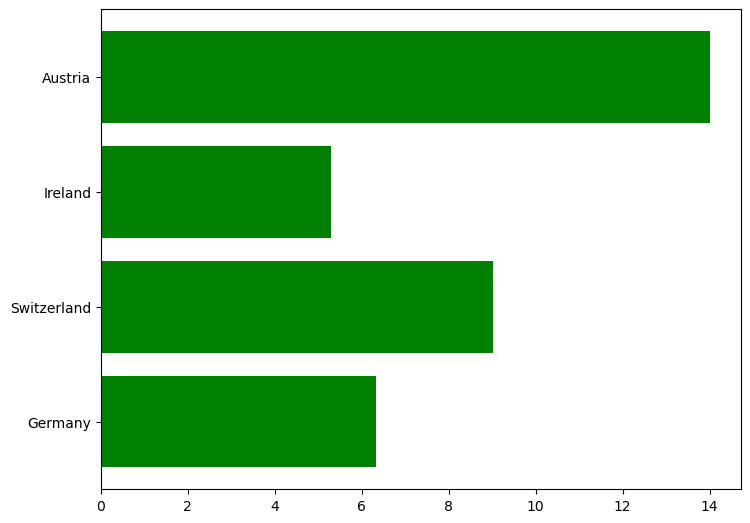

In [50]:
# Simple horizontal barplot for average Scores per country
eval1_df = combined_df.groupby("Country").agg({"Score": "mean"})
eval1_df["counts"] = combined_df["Country"].value_counts()
eval1_df = eval1_df.sort_values("counts").reset_index()

plot = plt.figure()
ax = plot.add_axes([0,0,1,1])
fields = eval1_df["Country"]
avg_scores = eval1_df["Score"]

ax.barh(fields, avg_scores, color=counts_color)

plt.show()

## F is not FAIR, its Findable!!!!!

In [56]:
# Creating subgroups of the metrics corresponding to the FAIR Principles
combined_df['Fair'] = combined_df.iloc[:, 0:4].sum(axis=1)
combined_df['Accessible'] = combined_df.iloc[:, 4:6].sum(axis=1)
combined_df['Interoperable'] = combined_df.iloc[:, 6:9].sum(axis=1)
combined_df['Reusable'] = combined_df.iloc[:, 9:12].sum(axis=1)

In [57]:
combined_df.head()

F1A  F1B  F2A  F2B  A1.1  A1.2  I1  I2  I3  R1.1  R1.2  R1.3  Score  \
0    2    0    1  1.0   2.0     2   1   1   0     2     2     1   15.0   
1    2    0    1  1.0   2.0     2   1   1   0     2     2     1   15.0   
2    2    0    1  1.0   2.0     2   1   1   0     2     2     1   15.0   
3    2    0    1  1.0   2.0     2   1   1   0     2     2     1   15.0   
4    2    0    1  1.0   2.0     2   1   1   0     2     2     1   15.0   

   Country  Fair  Accessible  Interoperable  Reusable  
0  Austria   4.0         4.0              2         5  
1  Austria   4.0         4.0              2         5  
2  Austria   4.0         4.0              2         5  
3  Austria   4.0         4.0              2         5  
4  Austria   4.0         4.0              2         5

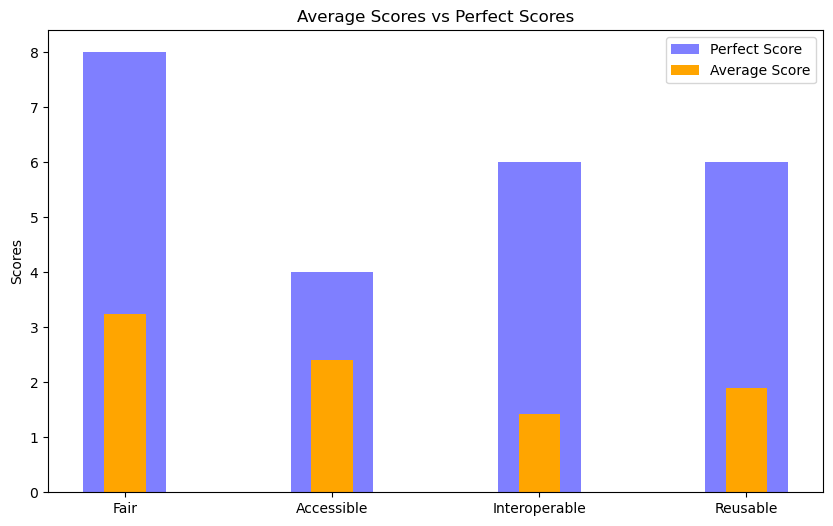

In [59]:
avg_1_4 = combined_df['Fair'].mean()
avg_5_6 = combined_df['Accessible'].mean()
avg_7_9 = combined_df['Interoperable'].mean()
avg_10_12 = combined_df['Reusable'].mean()

# List of perfect scores
perfect_scores = [8, 4, 6, 6]
# List of actual average scores
actual_scores = [avg_1_4, avg_5_6, avg_7_9, avg_10_12]

# Column names
columns = ['Fair', 'Accessible', 'Interoperable', 'Reusable']

# Indices for the bars
indices = np.arange(len(perfect_scores))
width = 0.4  # width of the bars

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar(indices, actual_scores, width=0.5*width, color='orange', label='Average Score')

# Customize the plot
plt.xticks(indices, columns)
plt.ylabel('Scores')
plt.title('Average Scores vs Perfect Scores')
plt.legend()

# Show the plot
plt.show()

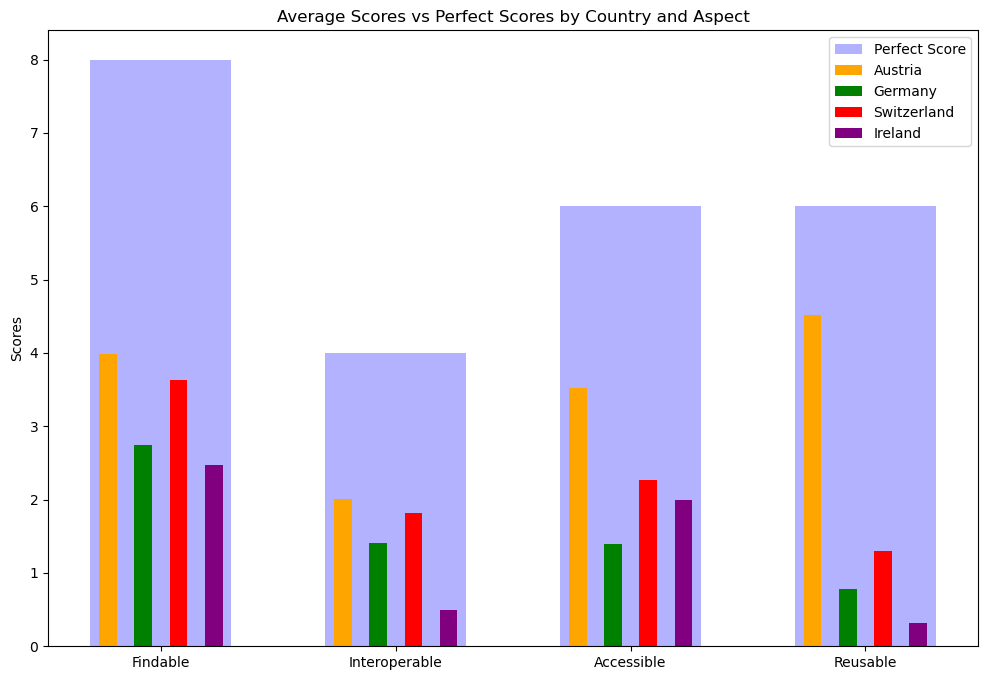

In [70]:
country_colors = {
    'Austria': 'orange',
    'Germany': 'green',
    'Switzerland': 'red',
    'Ireland': 'purple'
}
aspects = ['Findable', 'Interoperable', 'Accessible', 'Reusable']

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.15  # Width of the individual country bars
perfect_width = width * len(country_colors)  # Width of the perfect score bars
indices = np.arange(len(max_values))

# Plot bars for perfect scores
ax.bar(indices, max_values, width=perfect_width, color='blue', alpha=0.3, label='Perfect Score')

# Plot bars for each country
for i, (country, color) in enumerate(country_colors.items()):
    actual_scores = grouped.loc[country]
    positions = indices + (i - len(country_colors)/2 + 0.5) * width  # Center the smaller bars on the perfect score bar
    ax.bar(positions, actual_scores, width=0.5*width, color=color, label=country)

# Customize the plot
ax.set_xticks(indices)
ax.set_xticklabels(aspects)
ax.set_ylabel('Scores')
ax.set_title('Average Scores vs Perfect Scores by Country and Aspect')
ax.legend()


plt.show()

# Summary statistics

In [95]:
display(combined_df.groupby('Country').mean())
display(combined_df.groupby('Country').median())
display(combined_df.groupby('Country').min())
display(combined_df.groupby('Country').max())


F1A       F1B       F2A       F2B      A1.1      A1.2  \
Country                                                                   
Austria      1.989531  0.007003  0.994836  0.994766  1.989531  1.529603   
Germany      1.330395  0.000000  0.690544  0.720079  1.330395  0.059070   
Ireland      1.978915  0.005424  0.192208  0.295606  1.990221  0.009473   
Switzerland  1.978748  0.166212  0.662312  0.823357  1.986157  0.280562   

                   I1        I2        I3      R1.1      R1.2      R1.3  \
Country                                                                   
Austria      0.994836  0.994766  0.012450  1.529603  1.989531  0.994766   
Germany      0.690544  0.720079  0.000000  0.000000  0.059070  0.720079   
Ireland      0.191444  0.296104  0.007181  0.009778  0.011001  0.297250   
Switzerland  0.662312  0.823357  0.329889  0.280367  0.198674  0.823552   

                 Score      Fair  Accessible  Interoperable  Reusable  
Country                                                                
Austria      14.021221  3.986136    3.519134       2.002051  4.513900  
Germany       6.320256  2.741018    1.389464       1.410624  0.779149  
Ireland       5.284339  2.472040    1.999542       0.494729  0.318029  
Switzerland   9.015500  3.630630    2.266719       1.815559  1.302593

F1A  F1B  F2A  F2B  A1.1  A1.2   I1   I2   I3  R1.1  R1.2  R1.3  \
Country                                                                        
Austria      2.0  0.0  1.0  1.0   2.0   2.0  1.0  1.0  0.0   2.0   2.0   1.0   
Germany      2.0  0.0  1.0  1.0   2.0   0.0  1.0  1.0  0.0   0.0   0.0   1.0   
Ireland      2.0  0.0  0.0  0.0   2.0   0.0  0.0  0.0  0.0   0.0   0.0   0.0   
Switzerland  2.0  0.0  1.0  1.0   2.0   0.0  1.0  1.0  0.0   0.0   0.0   1.0   

             Score  Fair  Accessible  Interoperable  Reusable  
Country                                                        
Austria       15.0   4.0         4.0            2.0       5.0  
Germany        5.0   2.0         2.0            2.0       1.0  
Ireland        4.0   2.0         2.0            0.0       0.0  
Switzerland    9.0   4.0         2.0            2.0       1.0

F1A  F1B  F2A  F2B  A1.1  A1.2  I1  I2  I3  R1.1  R1.2  R1.3  \
Country                                                                     
Austria        0    0    0  0.0   0.0     0   0   0   0     0     0     0   
Germany        0    0    0  0.0   0.0     0   0   0   0     0     0     0   
Ireland        0    0    0  0.0   0.0     0   0   0   0     0     0     0   
Switzerland    0    0    0  0.0   0.0     0   0   0   0     0     0     0   

             Score  Fair  Accessible  Interoperable  Reusable  
Country                                                        
Austria        0.0   0.0         0.0              0         0  
Germany        0.0   0.0         0.0              0         0  
Ireland        0.0   0.0         0.0              0         0  
Switzerland    0.0   0.0         0.0              0         0

F1A  F1B  F2A  F2B  A1.1  A1.2  I1  I2  I3  R1.1  R1.2  R1.3  \
Country                                                                     
Austria        2    2    2  1.0   2.0     2   2   1   2     2     2     1   
Germany        2    0    1  2.0   2.0     2   1   2   0     0     2     2   
Ireland        2    2    1  2.0   2.0     2   1   2   2     2     2     2   
Switzerland    2    2    2  2.0   2.0     2   2   2   2     2     2     2   

             Score  Fair  Accessible  Interoperable  Reusable  
Country                                                        
Austria       19.0   6.0         4.0              5         5  
Germany       16.0   5.0         4.0              3         4  
Ireland       22.0   7.0         4.0              5         6  
Switzerland   24.0   8.0         4.0              6         6

In [239]:
len(combined_df[combined_df['Score']==24])

280

In [243]:
# All perfect scores are Swiss datasets - Bioinformatcs theme!
combined_df[(combined_df['Score']==24)&(combined_df['Country']!='Switzerland')]

Empty DataFrame
Columns: [F1A, F1B, F2A, F2B, A1.1, A1.2, I1, I2, I3, R1.1, R1.2, R1.3, Score, Country, Fair, Accessible, Interoperable, Reusable]
Index: []

In [244]:
combined_df[combined_df['Score']==24]

F1A  F1B  F2A  F2B  A1.1  A1.2  I1  I2  I3  R1.1  R1.2  R1.3  Score  \
23779    2    2    2  2.0   2.0     2   2   2   2     2     2     2   24.0   
23780    2    2    2  2.0   2.0     2   2   2   2     2     2     2   24.0   
23782    2    2    2  2.0   2.0     2   2   2   2     2     2     2   24.0   
23783    2    2    2  2.0   2.0     2   2   2   2     2     2     2   24.0   
23784    2    2    2  2.0   2.0     2   2   2   2     2     2     2   24.0   
...    ...  ...  ...  ...   ...   ...  ..  ..  ..   ...   ...   ...    ...   
24288    2    2    2  2.0   2.0     2   2   2   2     2     2     2   24.0   
24312    2    2    2  2.0   2.0     2   2   2   2     2     2     2   24.0   
24330    2    2    2  2.0   2.0     2   2   2   2     2     2     2   24.0   
24338    2    2    2  2.0   2.0     2   2   2   2     2     2     2   24.0   
24340    2    2    2  2.0   2.0     2   2   2   2     2     2     2   24.0   

           Country  Fair  Accessible  Interoperable  Reusable  
23779  Switzerland   8.0         4.0              6         6  
23780  Switzerland   8.0         4.0              6         6  
23782  Switzerland   8.0         4.0              6         6  
23783  Switzerland   8.0         4.0              6         6  
23784  Switzerland   8.0         4.0              6         6  
...            ...   ...         ...            ...       ...  
24288  Switzerland   8.0         4.0              6         6  
24312  Switzerland   8.0         4.0              6         6  
24330  Switzerland   8.0         4.0              6         6  
24338  Switzerland   8.0         4.0              6         6  
24340  Switzerland   8.0         4.0              6         6  

[280 rows x 18 columns]

### Some visualizations

In [96]:
dfq = combined_df.groupby('Country').mean()

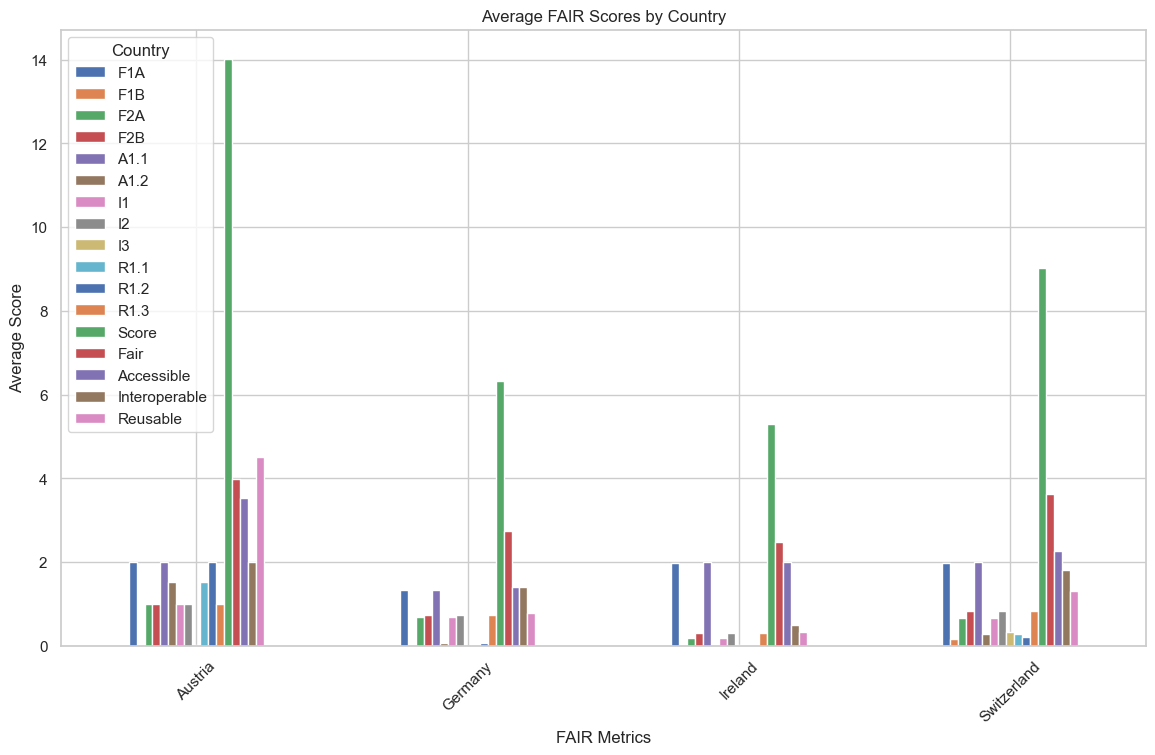

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plotting style
sns.set(style="whitegrid")

# Create a bar plot for the average FAIR scores
dfq.plot(kind='bar', figsize=(14, 8))
plt.title('Average FAIR Scores by Country')
plt.xlabel('FAIR Metrics')
plt.ylabel('Average Score')
plt.legend(title='Country')
plt.xticks(rotation=45)
plt.show()

All metric averages correspond to the overall order - no anomalies or significant outliers.

## melted Boxplot 

In [98]:
melted_scores = pd.melt(combined_df, id_vars='Country', var_name='FAIR Metric', value_name='Score')

C:\Users\local_MolnarM\Temp\ipykernel_93292\848975422.py:1: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  melted_scores = pd.melt(combined_df, id_vars='Country', var_name='FAIR Metric', value_name='Score')


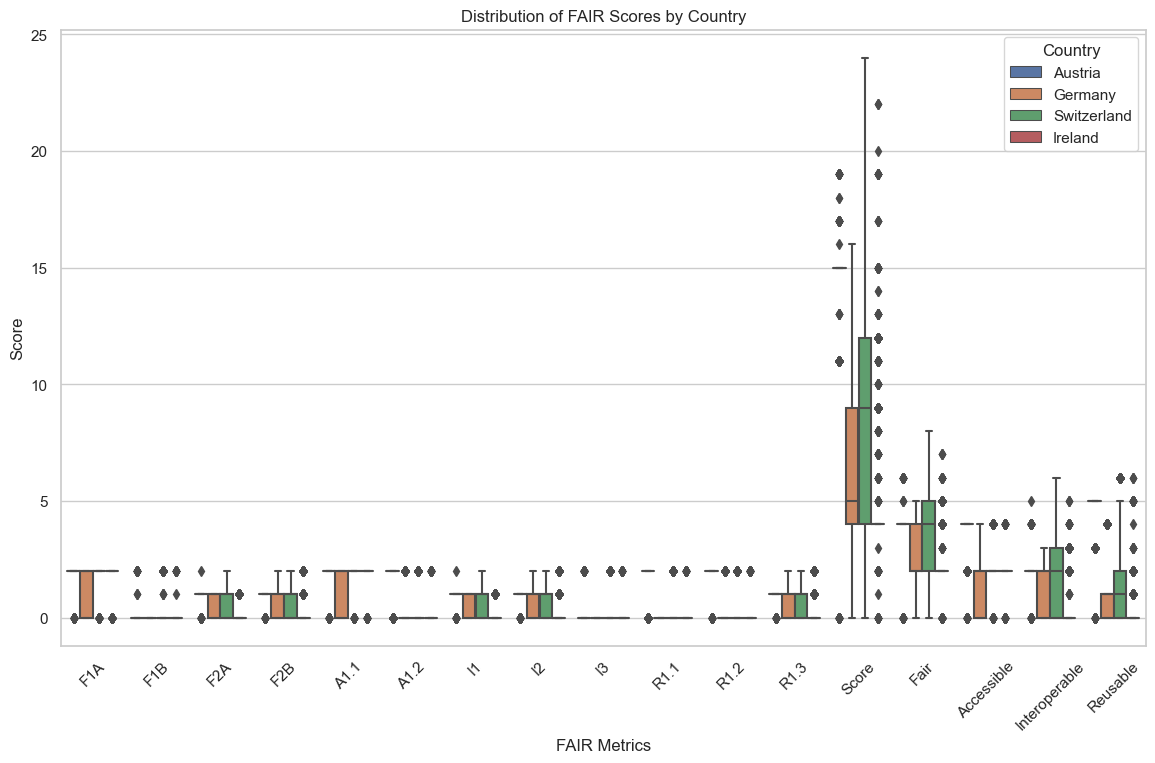

In [99]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='FAIR Metric', y='Score', hue='Country', data=melted_scores)

plt.title('Distribution of FAIR Scores by Country')
plt.xlabel('FAIR Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Country')
plt.show()

Austrian and Irish datasets achieve very similar scores (apparently the majority of the datasets are published by a handful of organizations that use consistently the same standards when publishing) - little variation - that's why the boxplots look like this. 

# Trend analysis

#### (for Austria we use the column metadata_modified for both cases as it does not have a metadata created column)

But it yields quite meaningless results as all the metadata was modified in 2022/23 so we leave it out from the visualizations.

In [126]:
# Convert the date columns to datetime
df['metadata_created'] = pd.to_datetime(df['metadata_modified'])
df['metadata_modified'] = pd.to_datetime(df['metadata_modified'])

df2['metadata_created'] = pd.to_datetime(df2['metadata_created'])
df2['metadata_modified'] = pd.to_datetime(df2['metadata_modified'])

df3['metadata_created'] = pd.to_datetime(df3['metadata_created'])
df3['metadata_modified'] = pd.to_datetime(df3['metadata_modified'])

df4['metadata_created'] = pd.to_datetime(df4['metadata_created'])
df4['metadata_modified'] = pd.to_datetime(df4['metadata_modified'])

# Extract the year from the datetime columns
df['year_created'] = df['metadata_created'].dt.year
df['year_modified'] = df['metadata_modified'].dt.year

df2['year_created'] = df2['metadata_created'].dt.year
df2['year_modified'] = df2['metadata_modified'].dt.year

df3['year_created'] = df3['metadata_created'].dt.year
df3['year_modified'] = df3['metadata_modified'].dt.year

df4['year_created'] = df4['metadata_created'].dt.year
df4['year_modified'] = df4['metadata_modified'].dt.year


In [121]:
# Adding back the scores to the original dataframes so we have the column names

df = pd.concat([df,df_combined.iloc[:,-14:]], axis = 1)
df2 = pd.concat([df2,df_combined2.iloc[:,-14:]], axis = 1)
df3 = pd.concat([df3,df_combined3.iloc[:,-14:]], axis = 1)
df4 = pd.concat([df4,df_combined4.iloc[:,-14:]], axis = 1)

In [127]:
# Define the FAIR metrics columns
fair_metrics = ['F1A', 'F1B', 'F2A', 'F2B', 'A1.1', 'A1.2', 'I1', 'I2', 'I3', 'R1.1', 'R1.2', 'R1.3']

# Aggregate average FAIR scores by year for each country
austria_trend = df.groupby('year_created')[fair_metrics].mean().reset_index()
germany_trend = df2.groupby('year_created')[fair_metrics].mean().reset_index()
switzerland_trend = df3.groupby('year_created')[fair_metrics].mean().reset_index()
ireland_trend = df4.groupby('year_created')[fair_metrics].mean().reset_index()


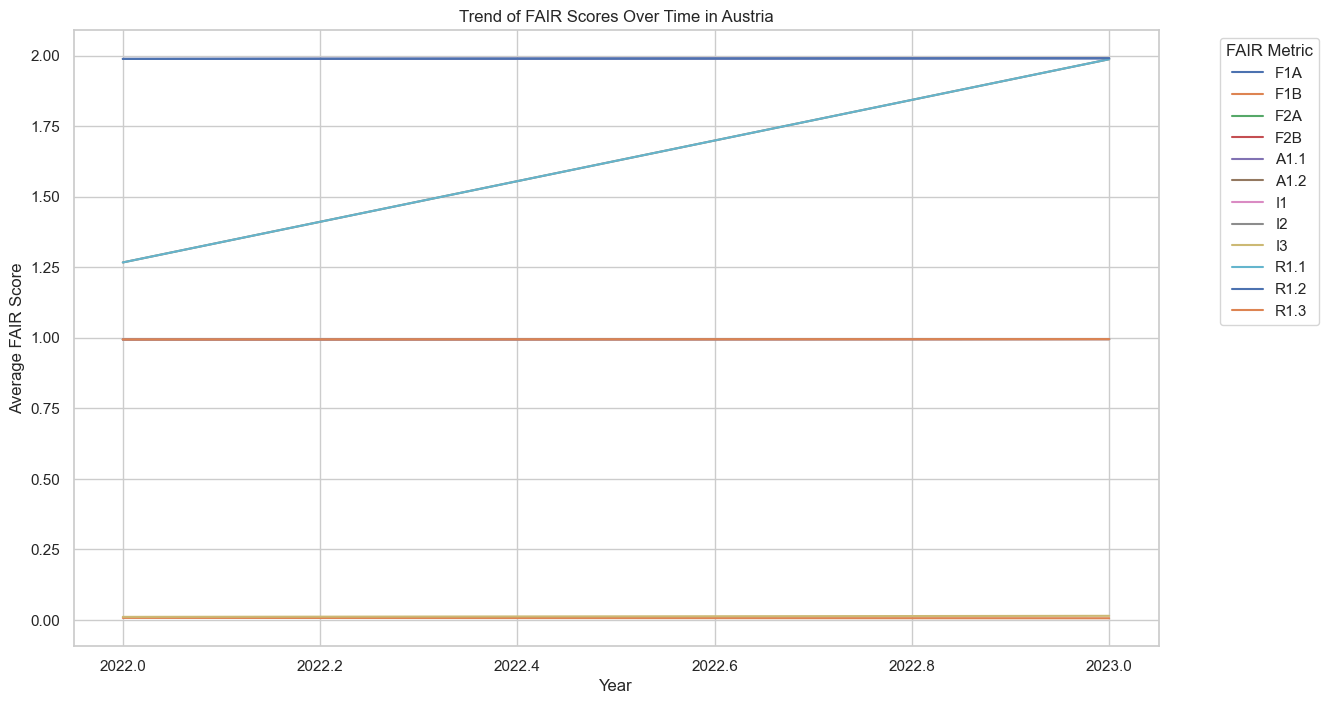

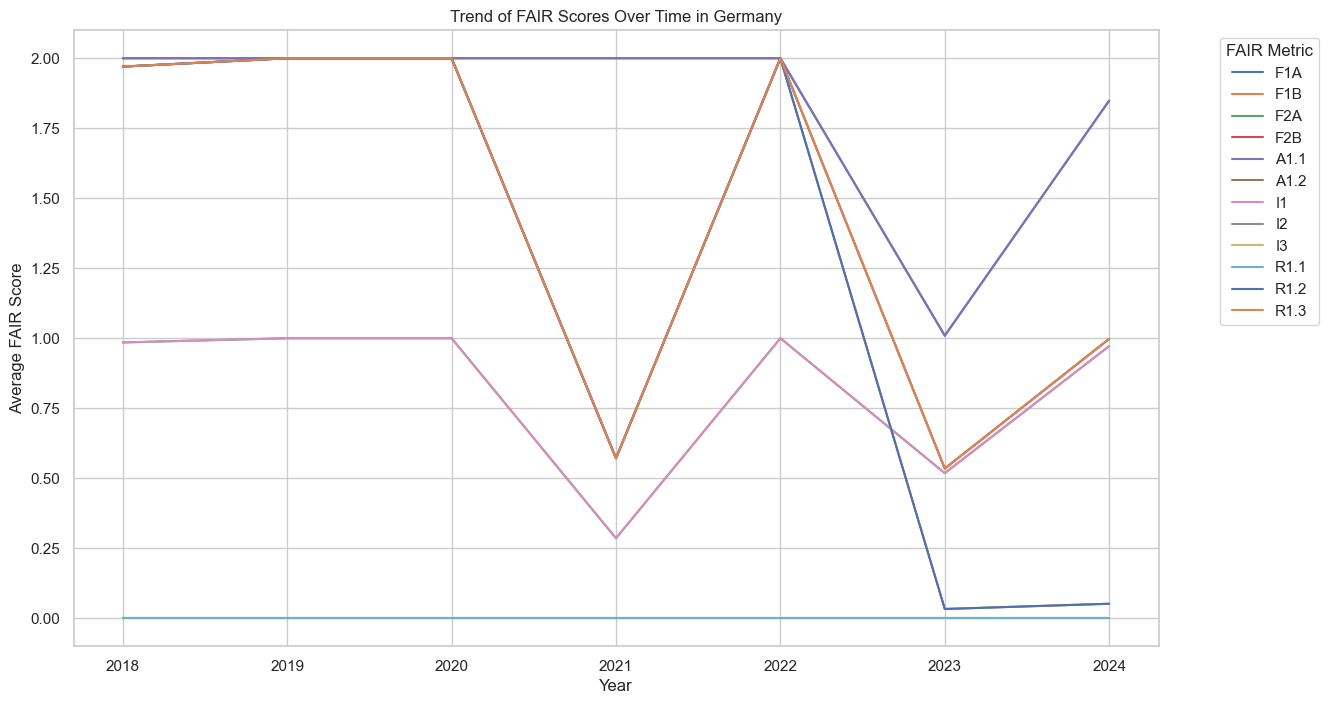

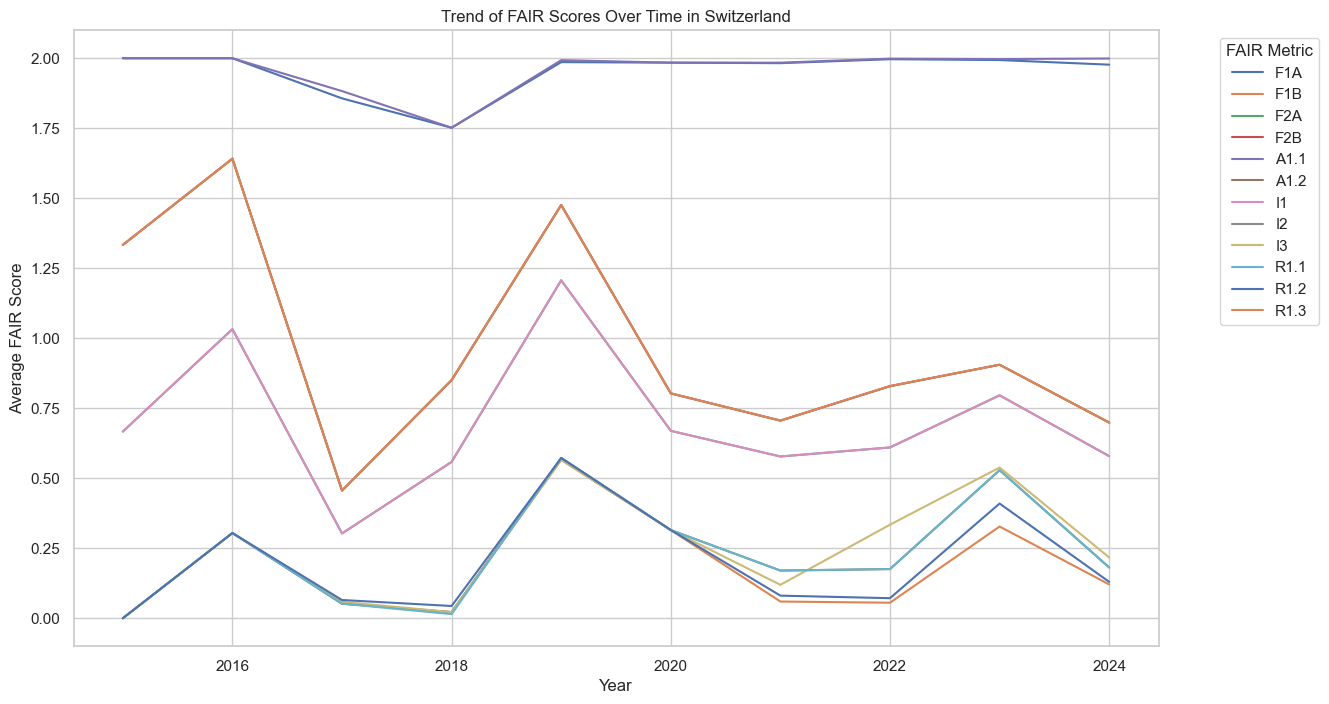

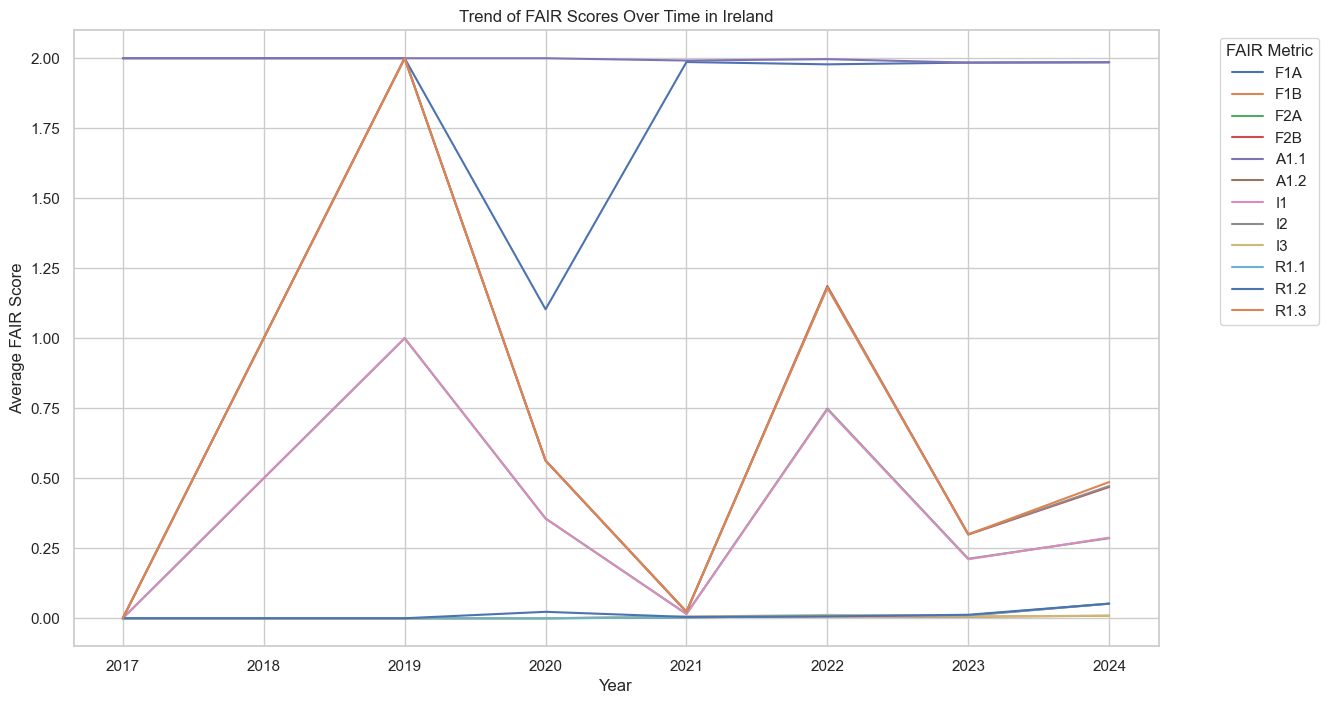

In [128]:
import matplotlib.pyplot as plt

# Function to plot trends
def plot_trends(country_trend, country_name):
    plt.figure(figsize=(14, 8))
    for metric in fair_metrics:
        plt.plot(country_trend['year_created'], country_trend[metric], label=metric)
    plt.title(f'Trend of FAIR Scores Over Time in {country_name}')
    plt.xlabel('Year')
    plt.ylabel('Average FAIR Score')
    plt.legend(title='FAIR Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Plot trends for each country
#plot_trends(austria_trend, 'Austria')
plot_trends(germany_trend, 'Germany')
plot_trends(switzerland_trend, 'Switzerland')
plot_trends(ireland_trend, 'Ireland')


Making the trendlines a bit smoother.

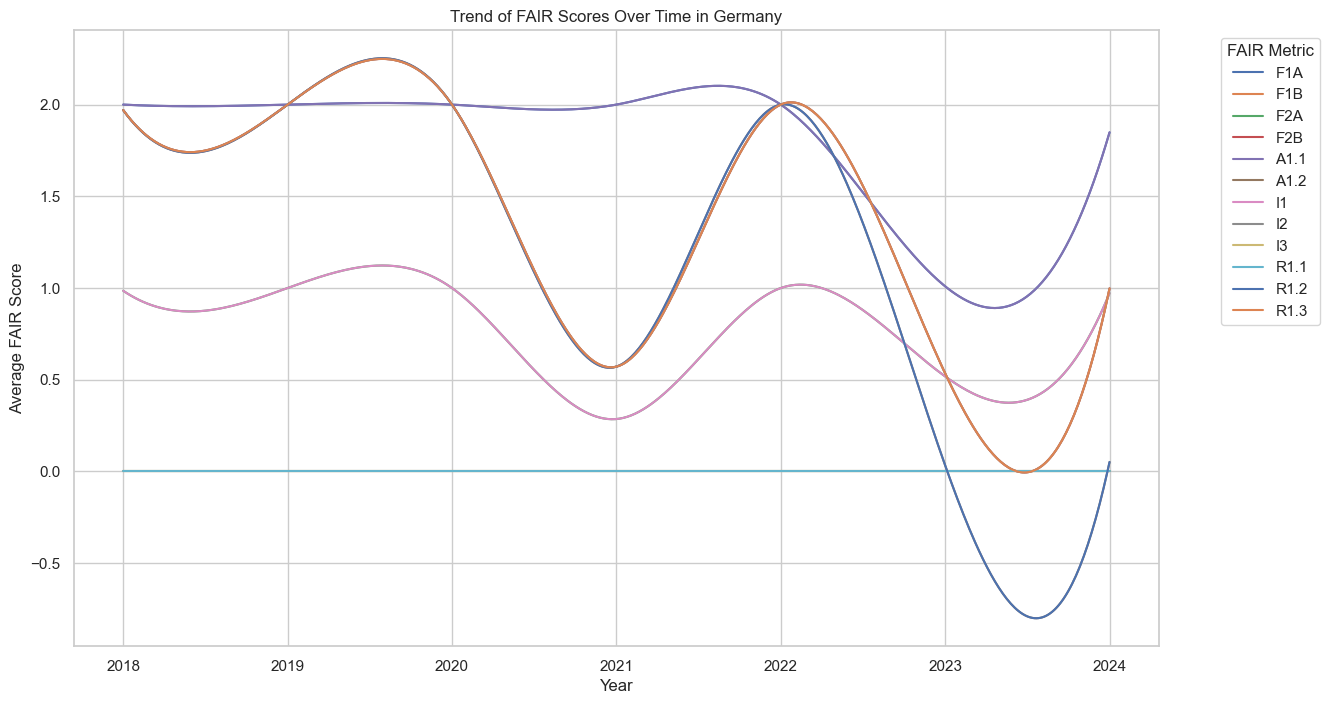

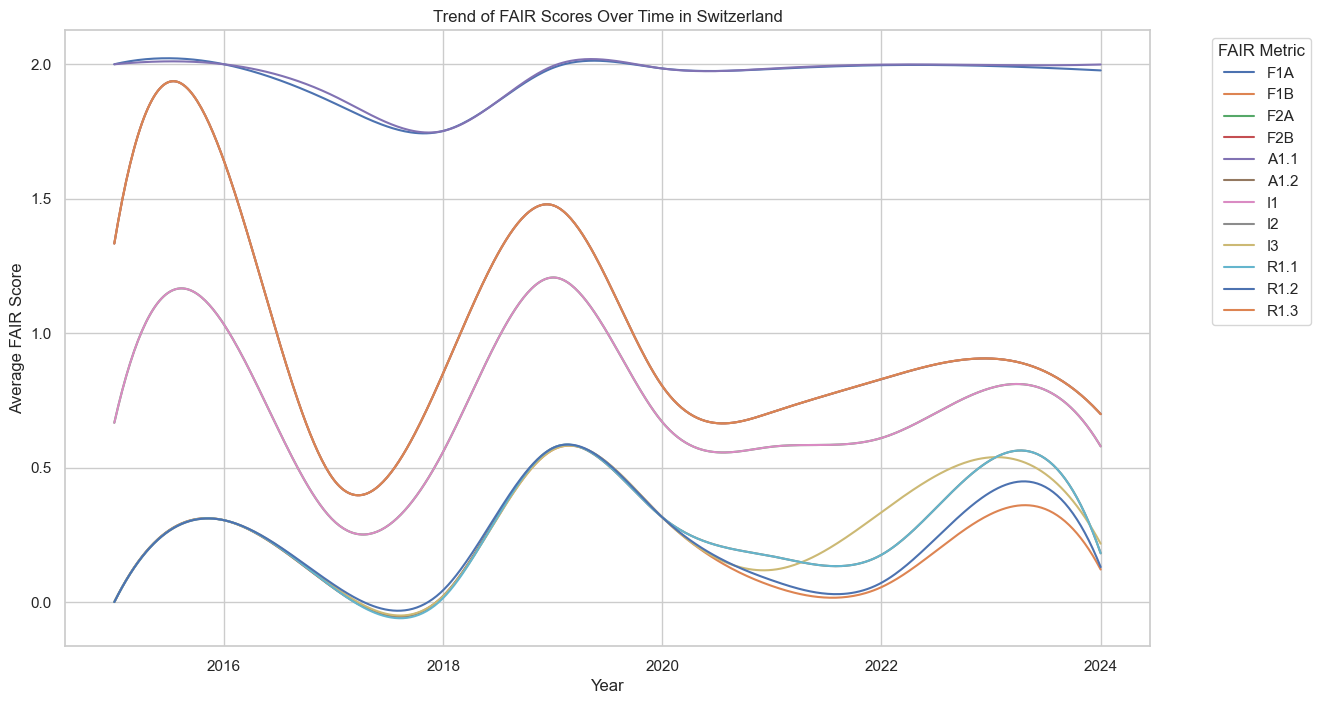

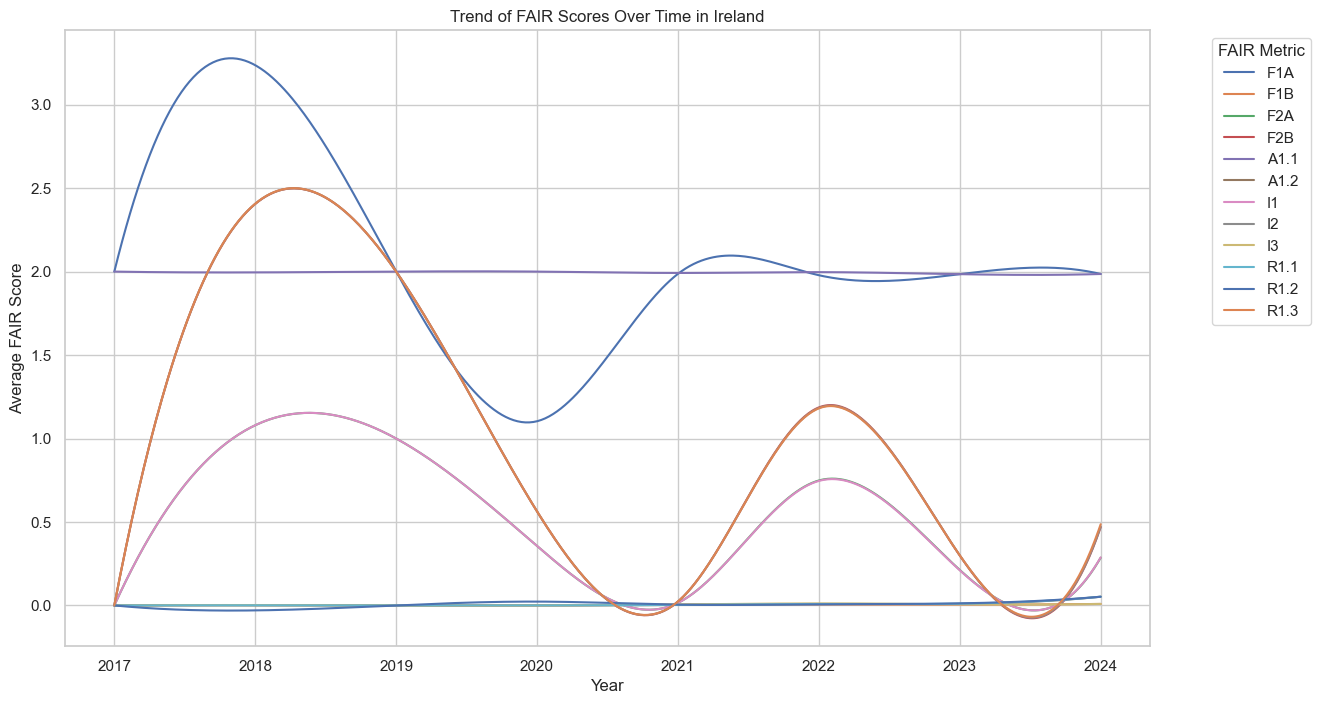

In [197]:
from scipy.interpolate import make_interp_spline

# Function to plot trends with smoother lines
def plot_trends(country_trend, country_name):
    plt.figure(figsize=(14, 8))
    x = country_trend['year_created']
    
    for metric in fair_metrics:
        y = country_trend[metric]
        X_Y_Spline = make_interp_spline(x, y)
        
        # Generate more x values to create a smooth curve
        X_ = np.linspace(min(x), max(x), 500)
        Y_ = X_Y_Spline(X_)
        
        plt.plot(X_, Y_, label=metric)
    
    plt.title(f'Trend of FAIR Scores Over Time in {country_name}')
    plt.xlabel('Year')
    plt.ylabel('Average FAIR Score')
    plt.legend(title='FAIR Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Plot trends for each country
# plot_trends(austria_trend, 'Austria')
plot_trends(germany_trend, 'Germany')
plot_trends(switzerland_trend, 'Switzerland')
plot_trends(ireland_trend, 'Ireland')


#### Trend average (equally weighted for the 3 countries that have "created" column)

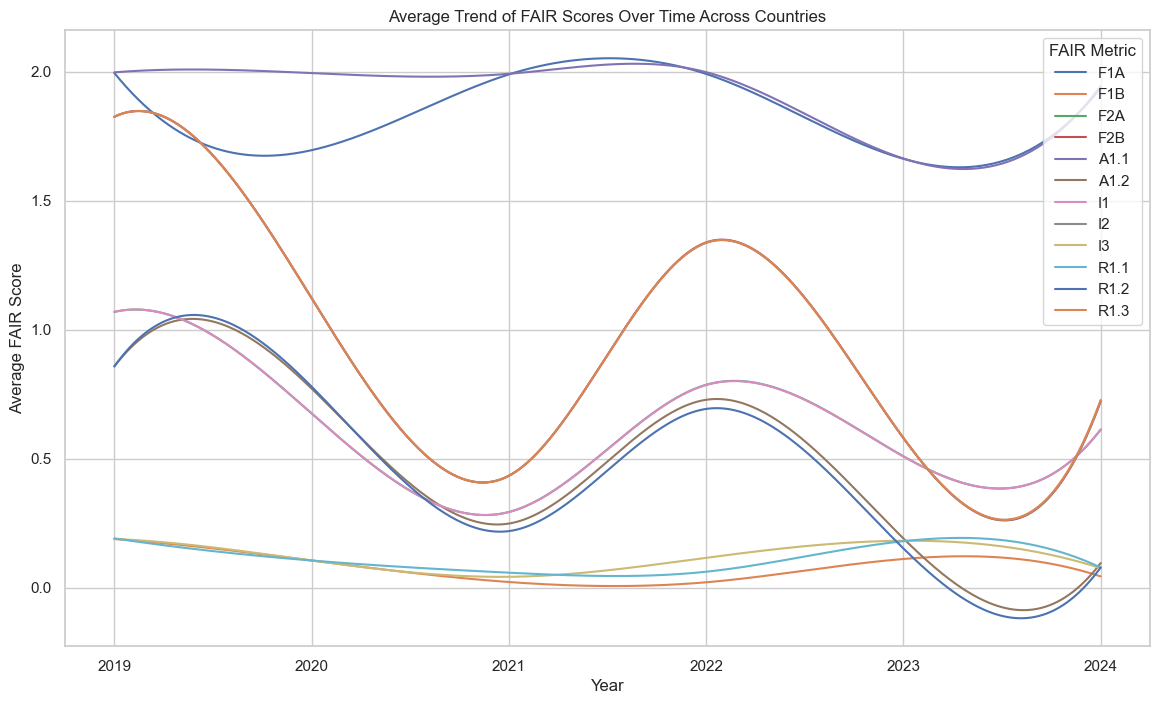

In [209]:
# Function to calculate average and plot trend
def plot_average_trend(countries):
    plt.figure(figsize=(14, 8))
    years = countries[0]['year_created']
    metrics = fair_metrics
    
    for idx, metric in enumerate(metrics):
        # Calculate average for each metric across all countries
        avg_scores = np.mean([country[metric] for country in countries], axis=0)
        
        # Smoothing the line
        X_Y_Spline = make_interp_spline(years, avg_scores)
        X_ = np.linspace(min(years), max(years), 500)
        Y_ = X_Y_Spline(X_)
        
        # Plotting
        plt.plot(X_, Y_, label=metric)
    
    plt.title('Average Trend of FAIR Scores Over Time Across Countries')
    plt.xlabel('Year')
    plt.ylabel('Average FAIR Score')
    plt.legend(title='FAIR Metric')
    plt.grid(True)
    plt.show()

# List of country data
countries = [germany_trend[1:], switzerland_trend[4:], ireland_trend[1:]]

# Plot the average trends
plot_average_trend(countries)

#### Conclusion:

No visible improvements over the last years for any country - if anything, there's a small downwards trend from 2022.

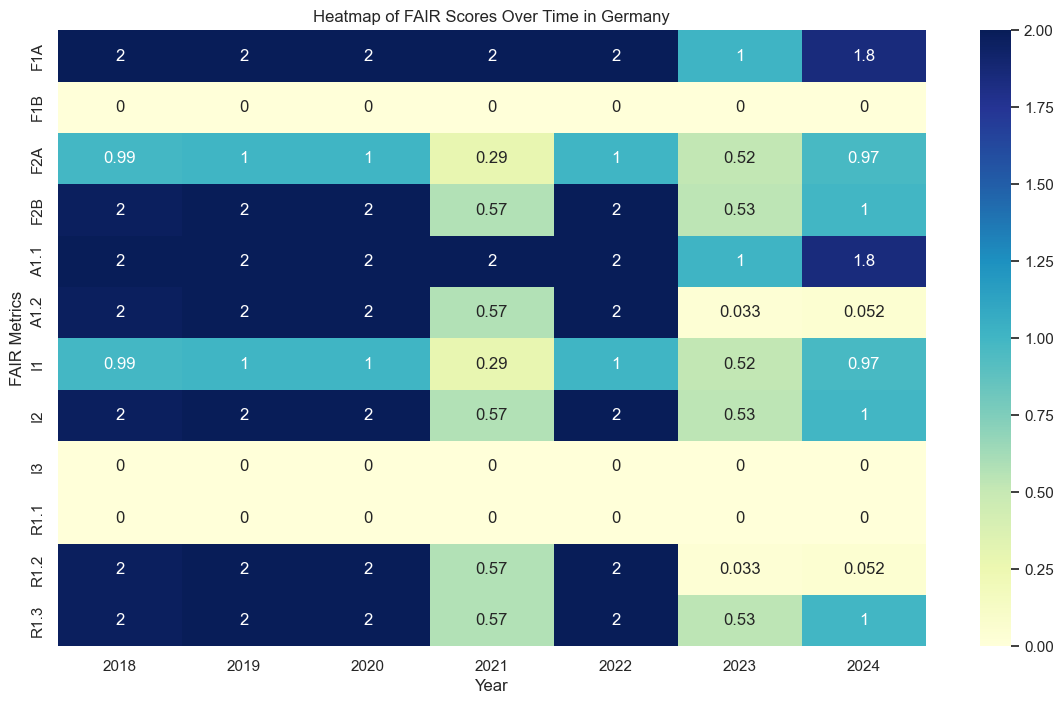

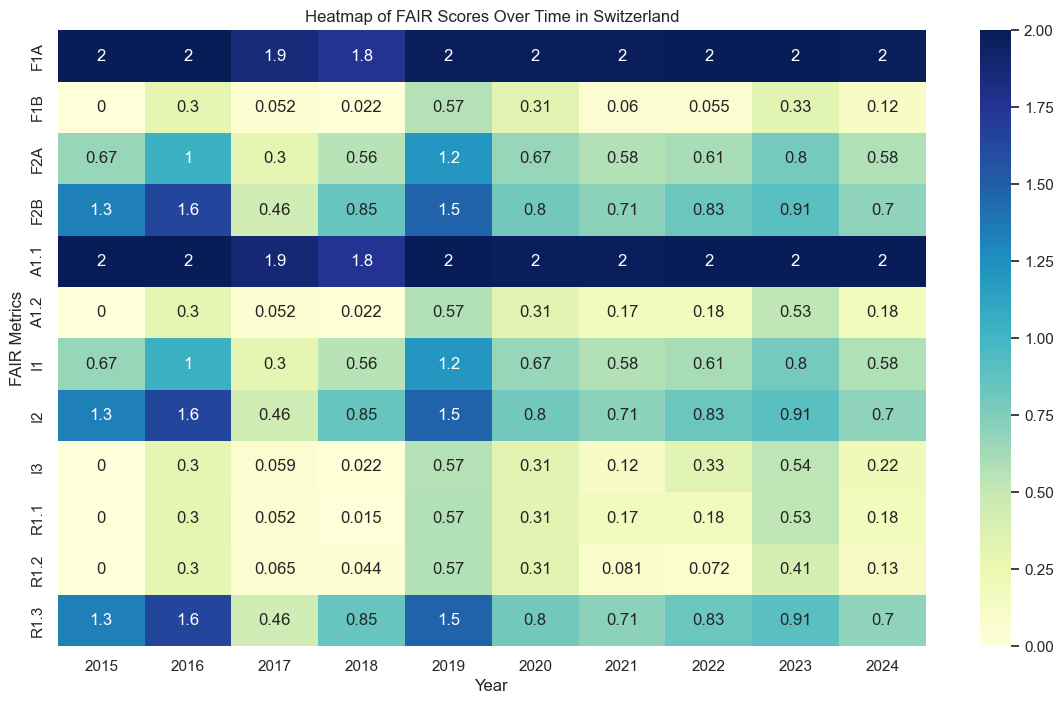

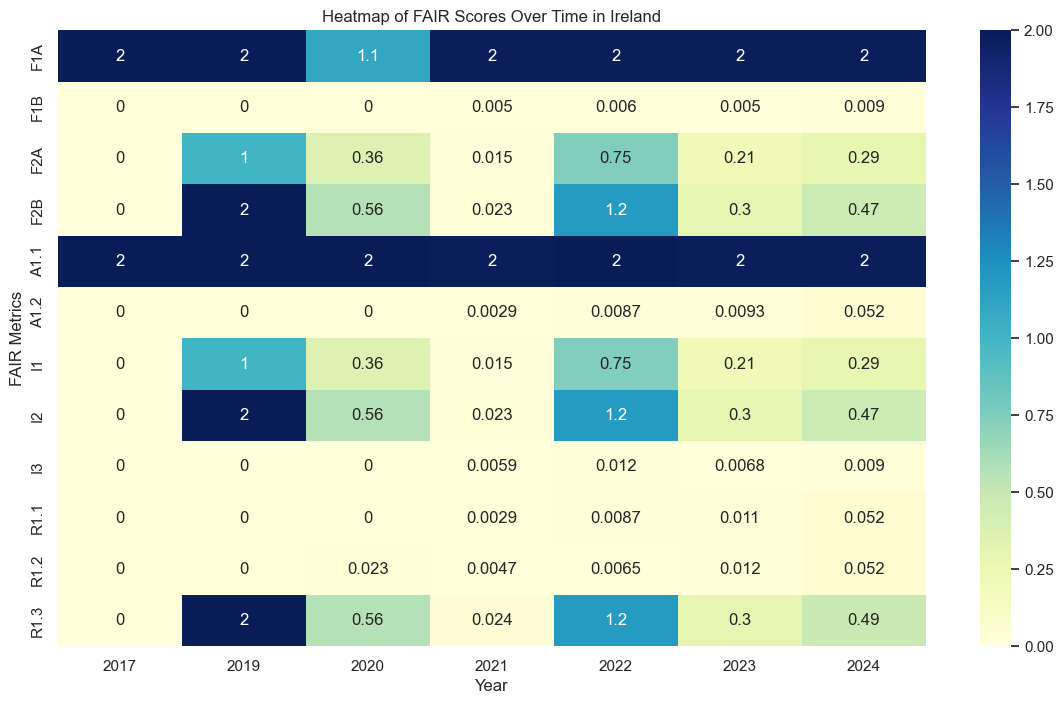

In [125]:
def plot_heatmap(country_trend, country_name):
    plt.figure(figsize=(14, 8))
    sns.heatmap(country_trend.set_index('year_created')[fair_metrics].T, annot=True, cmap="YlGnBu")
    plt.title(f'Heatmap of FAIR Scores Over Time in {country_name}')
    plt.xlabel('Year')
    plt.ylabel('FAIR Metrics')
    plt.show()

# Plot heatmaps for each country
#plot_heatmap(austria_trend, 'Austria')
plot_heatmap(germany_trend, 'Germany')
plot_heatmap(switzerland_trend, 'Switzerland')
plot_heatmap(ireland_trend, 'Ireland')

The heatmaps confirm the findings of the trendlines.

# Comparative analysis

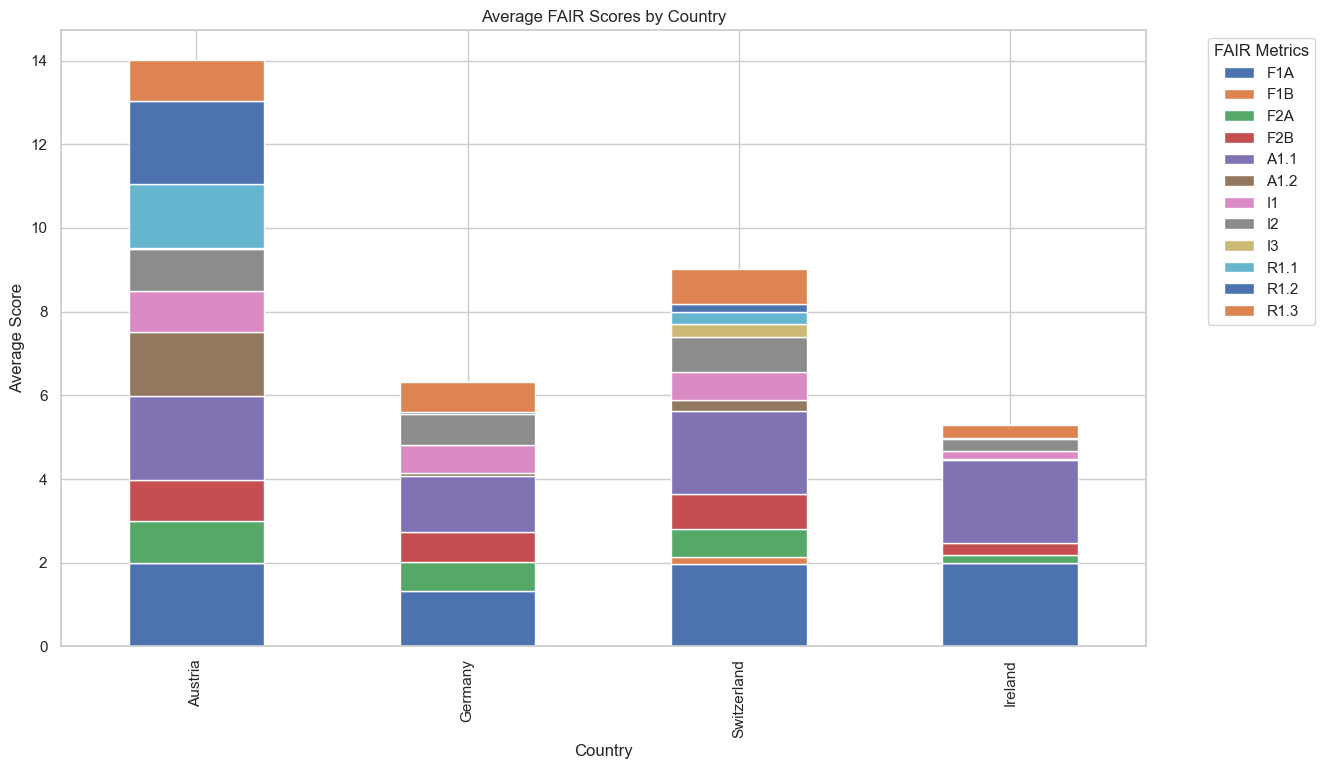

In [129]:
# Aggregate average FAIR scores for each country
mean_scores = {
    'Austria': df[fair_metrics].mean(),
    'Germany': df2[fair_metrics].mean(),
    'Switzerland': df3[fair_metrics].mean(),
    'Ireland': df4[fair_metrics].mean()
}

mean_scores_df = pd.DataFrame(mean_scores).T

# Create a stacked bar chart
mean_scores_df.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Average FAIR Scores by Country')
plt.xlabel('Country')
plt.ylabel('Average Score')
plt.legend(title='FAIR Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [136]:
fair_metrics

['F1A',
 'F1B',
 'F2A',
 'F2B',
 'A1.1',
 'A1.2',
 'I1',
 'I2',
 'I3',
 'R1.1',
 'R1.2',
 'R1.3']

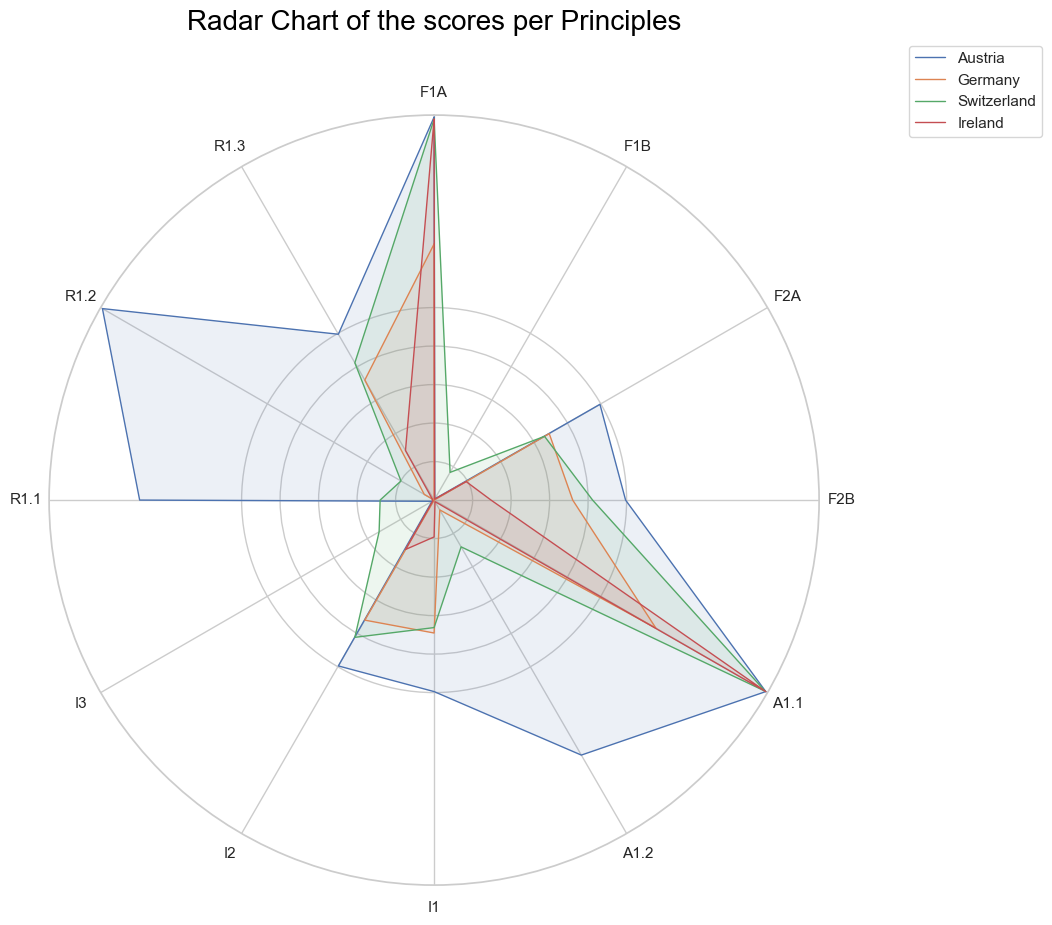

In [211]:
from math import pi

# Function to create radar chart
def plot_radar_chart(data, country_name):
    # Number of variables we're plotting
    categories = fair_metrics
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variables)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the radar plot
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories)

    ax.set_yticklabels([])

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1], color="grey", size=7)
    plt.ylim(0, max_score)

    # Ind1
    values = data.values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=country_name)
    ax.fill(angles, values, alpha=0.1)

    # Add a title
    plt.title(f'Radar Chart of the scores per Principles', size=20, color='black', y=1.1)

# Prepare data for radar chart
mean_scores_radar = {
    'Austria': df[fair_metrics].mean(),
    'Germany': df2[fair_metrics].mean(),
    'Switzerland': df3[fair_metrics].mean(),
    'Ireland': df4[fair_metrics].mean()
}

max_score = 2

# Plot radar charts for each country
plt.figure(figsize=(10, 10))
plot_radar_chart(mean_scores_radar['Austria'], 'Austria')
plot_radar_chart(mean_scores_radar['Germany'], 'Germany')
plot_radar_chart(mean_scores_radar['Switzerland'], 'Switzerland')
plot_radar_chart(mean_scores_radar['Ireland'], 'Ireland')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


Overall similar "strengths and weaknesses", but the data frm the Austrian portal tends to always have slightly higher scores.

F1B and I3 metrics are (virtually) always 0.

### License types, languages

Not designed as no meaningful results came out.

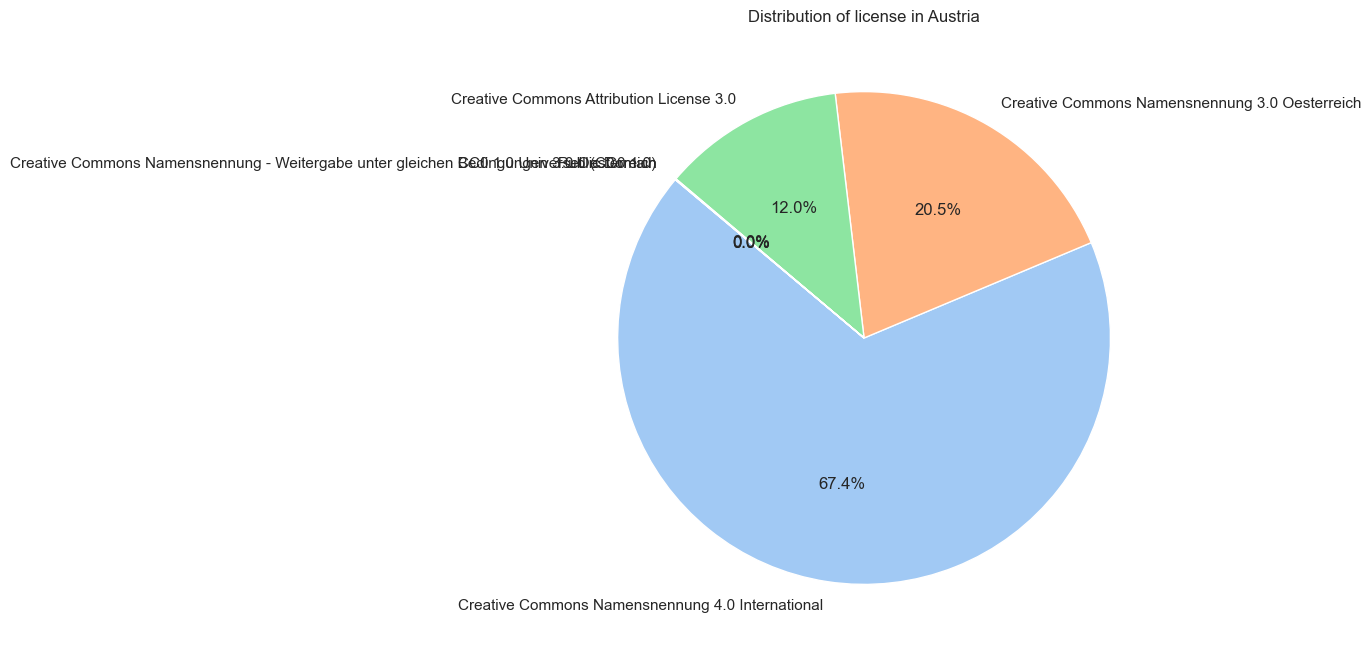

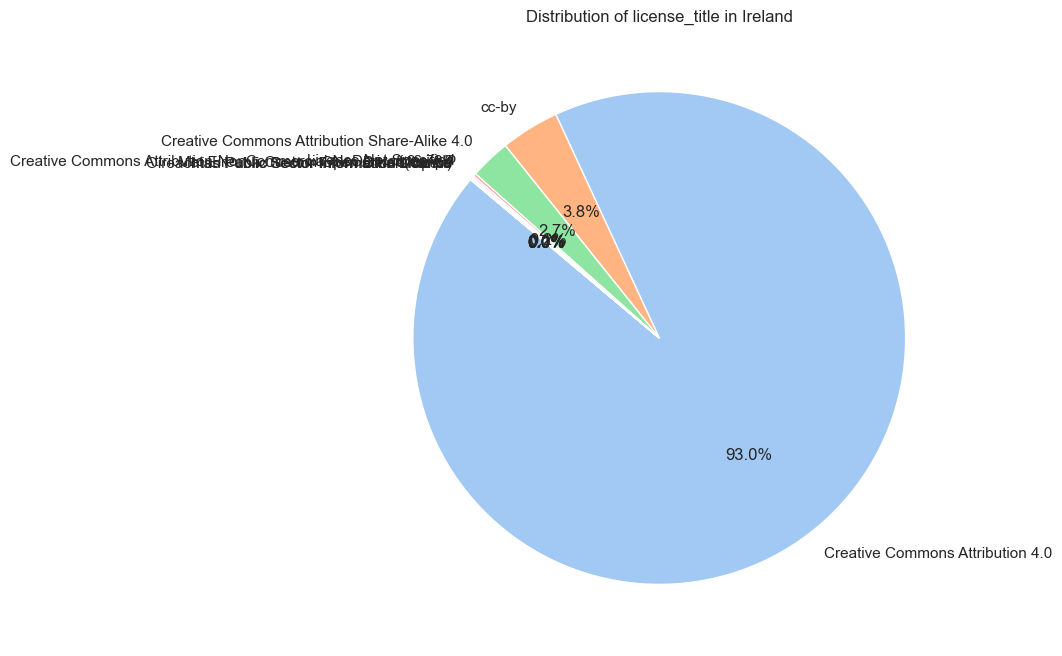

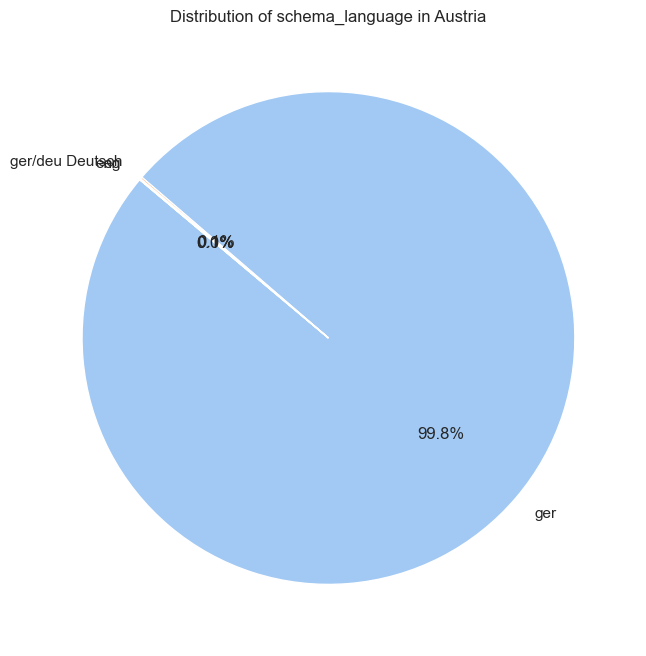

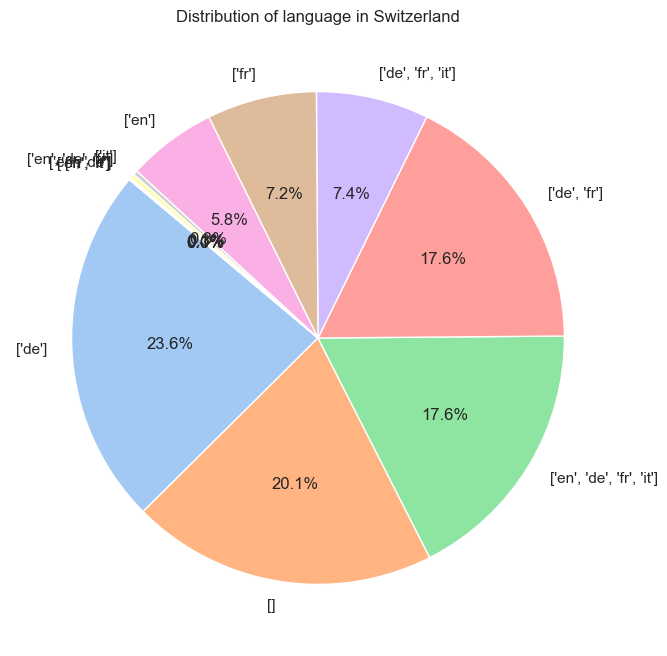

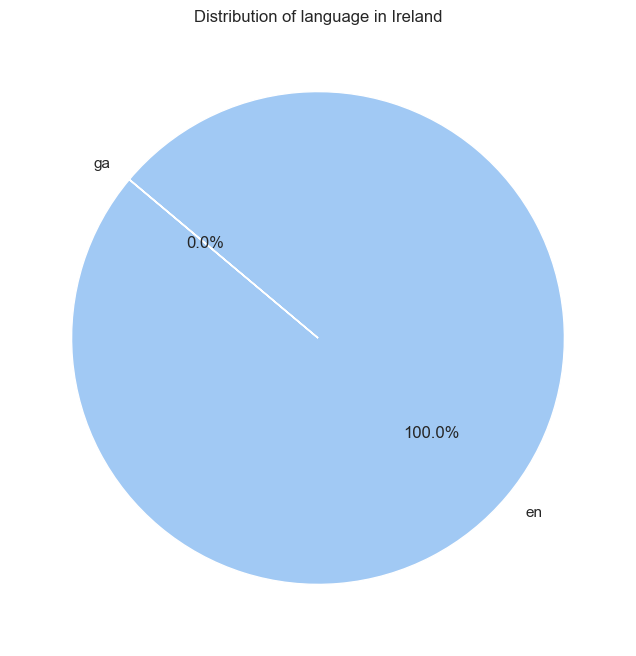

In [171]:
import matplotlib.pyplot as plt

# Function to plot pie charts for categorical data
def plot_pie_chart(data, column, country_name):
    plt.figure(figsize=(8, 8))
    data[column].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
    plt.title(f'Distribution of {column} in {country_name}')
    plt.ylabel('')
    plt.show()

# Plot pie charts for each country and a specific column, e.g., 'license_id'
plot_pie_chart(df, 'license', 'Austria')
#plot_pie_chart(df2, 'license_id', 'Germany')
#plot_pie_chart(df3, 'license_id', 'Switzerland')
plot_pie_chart(df4, 'license_title', 'Ireland')


plot_pie_chart(df, 'schema_language', 'Austria')
#plot_pie_chart(df2, 'language', 'Germany')
plot_pie_chart(df3, 'language', 'Switzerland')
plot_pie_chart(df4, 'language', 'Ireland')

In [177]:
len(df4)

13090

# Distribution of scores by country


Interestingly the overwhelming majority of Austrian and Irish datasets have almost identical scores, while the German and Swiss datasets take a much wider range.

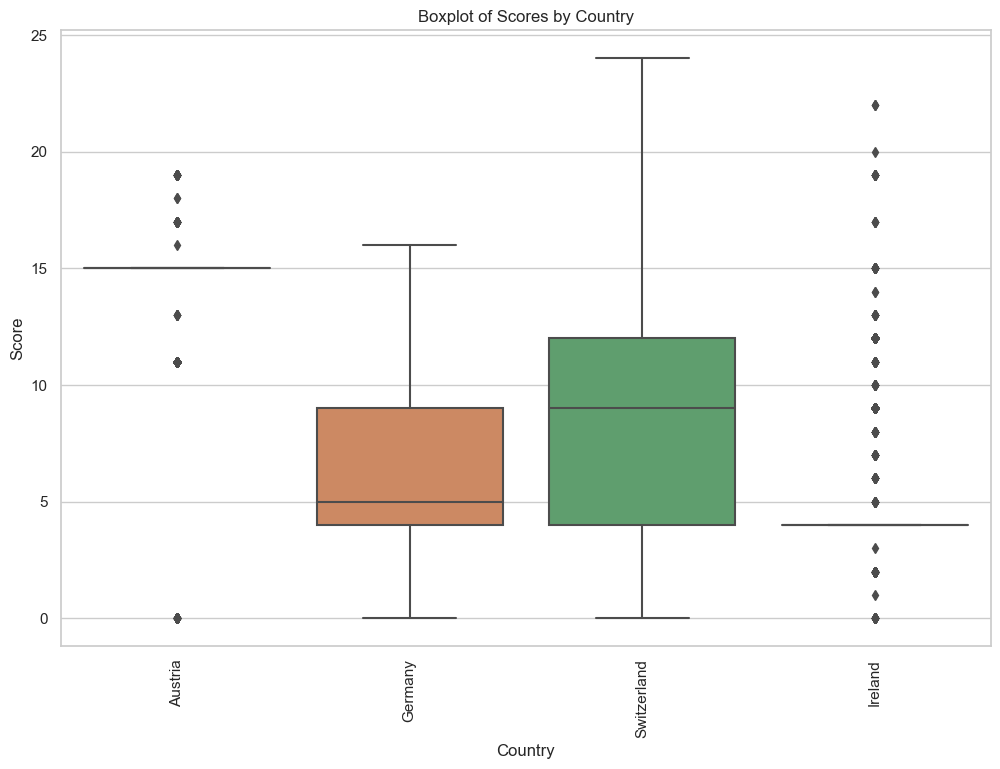

In [178]:
# Create the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Country', y='Score', data=combined_df)
plt.title('Boxplot of Scores by Country')
plt.xticks(rotation=90) # Rotate country names if they are long
plt.xlabel('Country')
plt.ylabel('Score')
plt.show()


## Interpreting some findings

 - A look into why some visualizations look this way

### Is it because they are published by the same people/organization?

In [228]:
display(df.publisher.value_counts())
#display(df.maintainer.value_counts())

Offenerhaushalt.at               6965
Nationalparks Austria            3531
Umweltbundesamt GmbH              791
Statistik Austria                 394
Land Vorarlberg                   379
                                 ... 
AEP Planung und Beratung GmbH       1
Monopolverwaltung GmbH              1
ASFINAG                             1
Stadtgemeinde Trofaiach             1
Gebetsberger ZT GmbH                1
Name: publisher, Length: 65, dtype: int64

In [229]:
display(df2.author.value_counts())
#display(df2.maintainer.value_counts())

Institut für Hygiene und Umwelt                                                                 3031
Landesbetrieb Geoinformation und Vermessung                                                     2895
Statistisches Amt für Hamburg und Schleswig-Holstein                                            2794
Hanse- und Universitätsstadt Rostock – Kataster-, Vermessungs- und Liegenschaftsamt              110
Behörde für Umwelt, Klima, Energie und Agrarwirtschaft (BUKEA)                                    61
Hanse- und Universitätsstadt Rostock – Hauptamt                                                   51
Hanse- und Universitätsstadt Rostock – Amt für Umwelt- und Klimaschutz                            33
Hanse- und Universitätsstadt Rostock – Stadtamt                                                   13
Behörde für Stadtentwicklung und Wohnen (BSW)                                                     10
Hanse- und Universitätsstadt Rostock – Amt für Stadtgrün, Naturschutz und Friedhofswesen   

In [236]:
#display(df3.author.value_counts())
display(df3.owner_org.value_counts())

4309c328-c618-4077-bcdc-378a21ee1b46    2917
aa742a0e-7ba4-4f65-ab9f-c587dec73891     627
1172ac79-c506-44cc-9463-ae60d96f09f8     593
6c1b8763-a767-40a4-993c-fc515db2e28c     583
8bedecea-4a19-4807-8d58-59b83b4a6f92     505
                                        ... 
0140936c-d4f9-4f5d-a6cb-929b90257cda       1
55e35d07-db62-4e97-89b3-c08d82b7ee68       1
645e9975-f9d4-48c7-b1c2-342fe6f9c94e       1
a4136229-3dc5-4353-947f-bcfdf8995735       1
fa7cf5ee-1353-4182-b679-4101afe66046       1
Name: owner_org, Length: 107, dtype: int64

In [238]:
display(df4.author.value_counts())

Fingal County Council                                   307
Open Data Liaison Officer                               274
Helena Campbell                                         263
South Dublin County Council                             155
Dublin City Council                                      99
Deirdre Kelly                                            75
Geological Survey of Ireland                             45
Environmental Protection Agency                          44
DLR GIS Officer                                          41
National Biodiversity Data Centre                        29
Dún Laoghaire-Rathdown County Council                    28
Not supplied                                             11
Data and Analytics Unit                                  10
Data Officer                                              7
Roscommon County Council                                  7
Data & Analytics Unit                                     5
Wexford County Council                  

In [231]:
df3.head()

Unnamed: 0                             owner_org  \
0           0  b3d5c5d8-f736-459e-b23b-fe0ea6196cf2   
1          25  1e4cc1ec-05f2-4801-821e-492a8199dced   
2          26  1e4cc1ec-05f2-4801-821e-492a8199dced   
3          27  1e4cc1ec-05f2-4801-821e-492a8199dced   
4          29  51ffc9d5-bf18-4bb4-9b26-ad9b45a60e14   

                                          maintainer  \
0                                      Sara Schärrer   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  Stadt Winterthur, Stadtentwicklung der Stadt W...   

                      issued  \
0        2023-03-02T00:00:00   
1        2023-08-30T00:00:00   
2        2024-06-06T00:00:00   
3        2024-01-31T00:00:00   
4  2022-09-20T17:10:34+01:00   

                                      title_for_slug qualified_relations  \
0                Tierseuchenmeldungen in der Schweiz                  []   
1  klimaanalyse-windgeschwindigkeit-nacht-zukunft...                  []   
2   gebaudeflachen-mit-adressen-amtliche-vermessung2                  []   
3                                   kantonsstrassen1                  []   
4  beschaftigtendichte-in-der-stadt-winterthur-ab...                  []   

   private             maintainer_email  num_tags  \
0    False  sara.schaerrer@blv.admin.ch         9   
1    False                          NaN         0   
2    False                          NaN         0   
3    False                          NaN         0   
4    False             statistik@win.ch         4   

                                      contact_points  \
0  [{'name': 'Kompetenzzentrum Daten', 'email': '...   
1  [{'email': 'afu@bd.so.ch', 'name': 'afu@bd.so....   
2  [{'email': 'agi@bd.so.ch', 'name': 'agi@bd.so....   
3  [{'email': 'avt@bd.so.ch', 'name': 'avt@bd.so....   
4  [{'email': 'statistik@win.ch', 'name': 'Stadt ...   

                                            keywords  \
0  {'fr': ['animal', 'veterinaire', 'epizootie'],...   
1  {'fr': [], 'de': ['klimaanalyse'], 'en': [], '...   
2  {'fr': [], 'de': ['gebaude', 'adresse', 'egid'...   
3  {'fr': [], 'de': ['strasse', 'strassen', 'verk...   
4  {'fr': [], 'de': ['bevoelkerung', 'gemeinden',...   

                                           temporals  \
0  [{'start_date': '1991-01-01T00:00:00', 'end_da...   
1                                                 []   
2                                                 []   
3                                                 []   
4  [{'start_date': '1995-01-01T00:00:00', 'end_da...   

                                     id           metadata_created  \
0  702ddd5c-ca98-4a78-96ef-9aafdbea8f2d 2023-05-05 06:30:17.188021   
1  d2b483d0-838c-4a3b-b93e-16685da0b0f0 2024-06-19 05:37:57.613414   
2  0f3681b9-7508-421f-8f23-f482de9a8485 2024-06-19 05:34:29.756561   
3  fa77acc4-d44d-455b-a4b1-42c06824ff33 2024-06-19 05:33:30.010765   
4  86419980-f6af-462a-a672-27ed54f77299 2022-11-15 16:04:52.337827   

  conforms_to          metadata_modified author  author_email  \
0          [] 2024-06-19 07:29:52.862215    NaN           NaN   
1          [] 2024-06-19 05:37:57.613423    NaN           NaN   
2          [] 2024-06-19 05:34:29.756569    NaN           NaN   
3          [] 2024-06-19 05:33:30.010773    NaN           NaN   
4          [] 2024-06-19 04:12:54.928353    NaN           NaN   

                                           relations   state  version  \
0  [{'url': 'https://www.fedlex.admin.ch/eli/cc/1...  active      NaN   
1  [{'url': 'https://www.geocat.ch/geonetwork/srv...  active      NaN   
2  [{'url': 'https://www.geocat.ch/geonetwork/srv...  active      NaN   
3  [{'url': 'https://www.geocat.ch/geonetwork/srv...  active      NaN   
4  [{'url': 'https://openzh.github.io/starter-cod...  active      NaN   

  relationships_as_object  license_id     type  \
0                      []         NaN  dataset   
1   

### Lets look a bit more into the different values they take to confirm our findings from the boxplots

In [216]:
combined_df.Score.value_counts()

4.0     17194
15.0    10849
9.0      6537
11.0     3851
5.0      3064
12.0     2800
16.0      719
21.0      303
24.0      280
19.0      264
0.0       169
17.0      145
13.0      144
2.0       103
7.0        30
6.0        29
8.0        24
20.0       23
10.0       15
22.0        6
14.0        4
18.0        4
1.0         1
3.0         1
Name: Score, dtype: int64

In [187]:
combined_df[fair_metrics].value_counts()

F1A  F1B  F2A  F2B  A1.1  A1.2  I1  I2  I3  R1.1  R1.2  R1.3
2    0    0    0.0  2.0   0     0   0   0   0     0     0       17194
          1    1.0  2.0   2     1   1   0   2     2     1       10752
                          0     1   1   0   0     0     1        6531
                                                  2     1        3249
0    0    1    1.0  0.0   0     1   1   0   0     0     1        3051
                                                                ...  
                                                  2     1           1
                                        2   0     2     1           1
2    0    1    2.0  2.0   0     1   2   2   0     0     2           1
               1.0  2.0   2     1   1   0   2     2     0           1
               2.0  2.0   0     1   1   0   0     0     2           1
Length: 71, dtype: int64

In [181]:
df[fair_metrics].value_counts()

F1A  F1B  F2A  F2B  A1.1  A1.2  I1  I2  I3  R1.1  R1.2  R1.3
2    0    1    1    2     2     1   1   0   2     2     1       10724
                          0     1   1   0   0     2     1        3243
0    0    0    0    0     0     0   0   0   0     0     0          74
2    0    1    1    2     2     1   1   2   2     2     1          44
     2    1    1    2     2     1   1   2   2     2     1          40
                          0     1   1   0   0     2     1           7
     1    1    1    2     2     1   1   2   2     2     1           2
     0    2    1    2     2     2   1   2   2     2     1           1
     1    1    1    2     2     1   1   0   2     2     1           1
     2    1    1    2     0     1   1   2   0     2     1           1
dtype: int64

99% of the Austrian datasets can be described by two score-combinations (out of the multiple thousand potential ones), which suggests there's a strong framework/recommendation how these datasets should be published. (In total 10 unique combinations)

In [183]:
df4[fair_metrics].value_counts()

F1A  F1B  F2A  F2B  A1.1  A1.2  I1  I2  I3  R1.1  R1.2  R1.3
2    0    0    0.0  2.0   0     0   0   0   0     0     0       10428
          1    2.0  2.0   0     1   2   0   0     0     2        1331
               1.0  2.0   0     1   1   0   0     0     1        1008
0    0    0    0.0  2.0   0     0   0   0   0     0     0          71
                    0.0   0     0   0   0   0     0     0          38
2    0    1    1.0  2.0   2     1   1   0   2     2     1          28
     2    1    1.0  2.0   2     1   1   2   2     2     1          14
     0    1    1.0  2.0   0     0   0   0   0     0     0          12
          0    0.0  2.0   0     0   0   0   0     0     1          10
          1    1.0  2.0   0     1   2   0   0     0     2          10
          0    0.0  2.0   0     1   1   0   0     0     1          10
     2    1    1.0  2.0   0     1   1   2   0     0     1           9
0    0    1    2.0  0.0   0     1   2   0   0     0     2           9
2    0    1    1.0  2.0   0  

Also for Ireland the majority of datasets only differ in very few principles, but there are a couple that take also different combinations.

In [185]:
df2[fair_metrics].value_counts()

F1A  F1B  F2A  F2B  A1.1  A1.2  I1  I2  I3  R1.1  R1.2  R1.3
0    0    1    1    0     0     1   1   0   0     0     1       3035
2    0    1    1    2     0     1   1   0   0     0     1       2963
          0    0    2     0     0   0   0   0     0     0       2805
          1    2    2     2     1   2   0   0     2     2        268
0    0    0    0    0     0     0   0   0   0     0     0          3
dtype: int64

In [186]:
df3[fair_metrics].value_counts()

F1A  F1B  F2A  F2B  A1.1  A1.2  I1  I2  I3  R1.1  R1.2  R1.3
2    0    0    0    2     0     0   0   0   0     0     0       3961
          1    1    2     0     1   1   0   0     0     1       2560
               2    2     0     1   2   0   0     0     2       1469
               1    2     0     1   1   2   0     0     1        567
               2    2     2     1   2   0   2     0     2        434
     2    2    1    2     2     2   1   2   2     2     1        303
               2    2     2     2   2   2   2     2     2        280
          1    1    2     2     1   1   2   2     2     1        209
     0    1    1    2     0     1   1   2   0     2     1        121
                          2     1   1   2   2     0     1         90
                                                  2     1         57
0    0    0    0    0     0     0   0   0   0     0     0         54
2    2    1    1    2     2     1   1   2   2     0     1         33
0    0    0    0    2     0     0   0   0 

### Trying out some visualizations

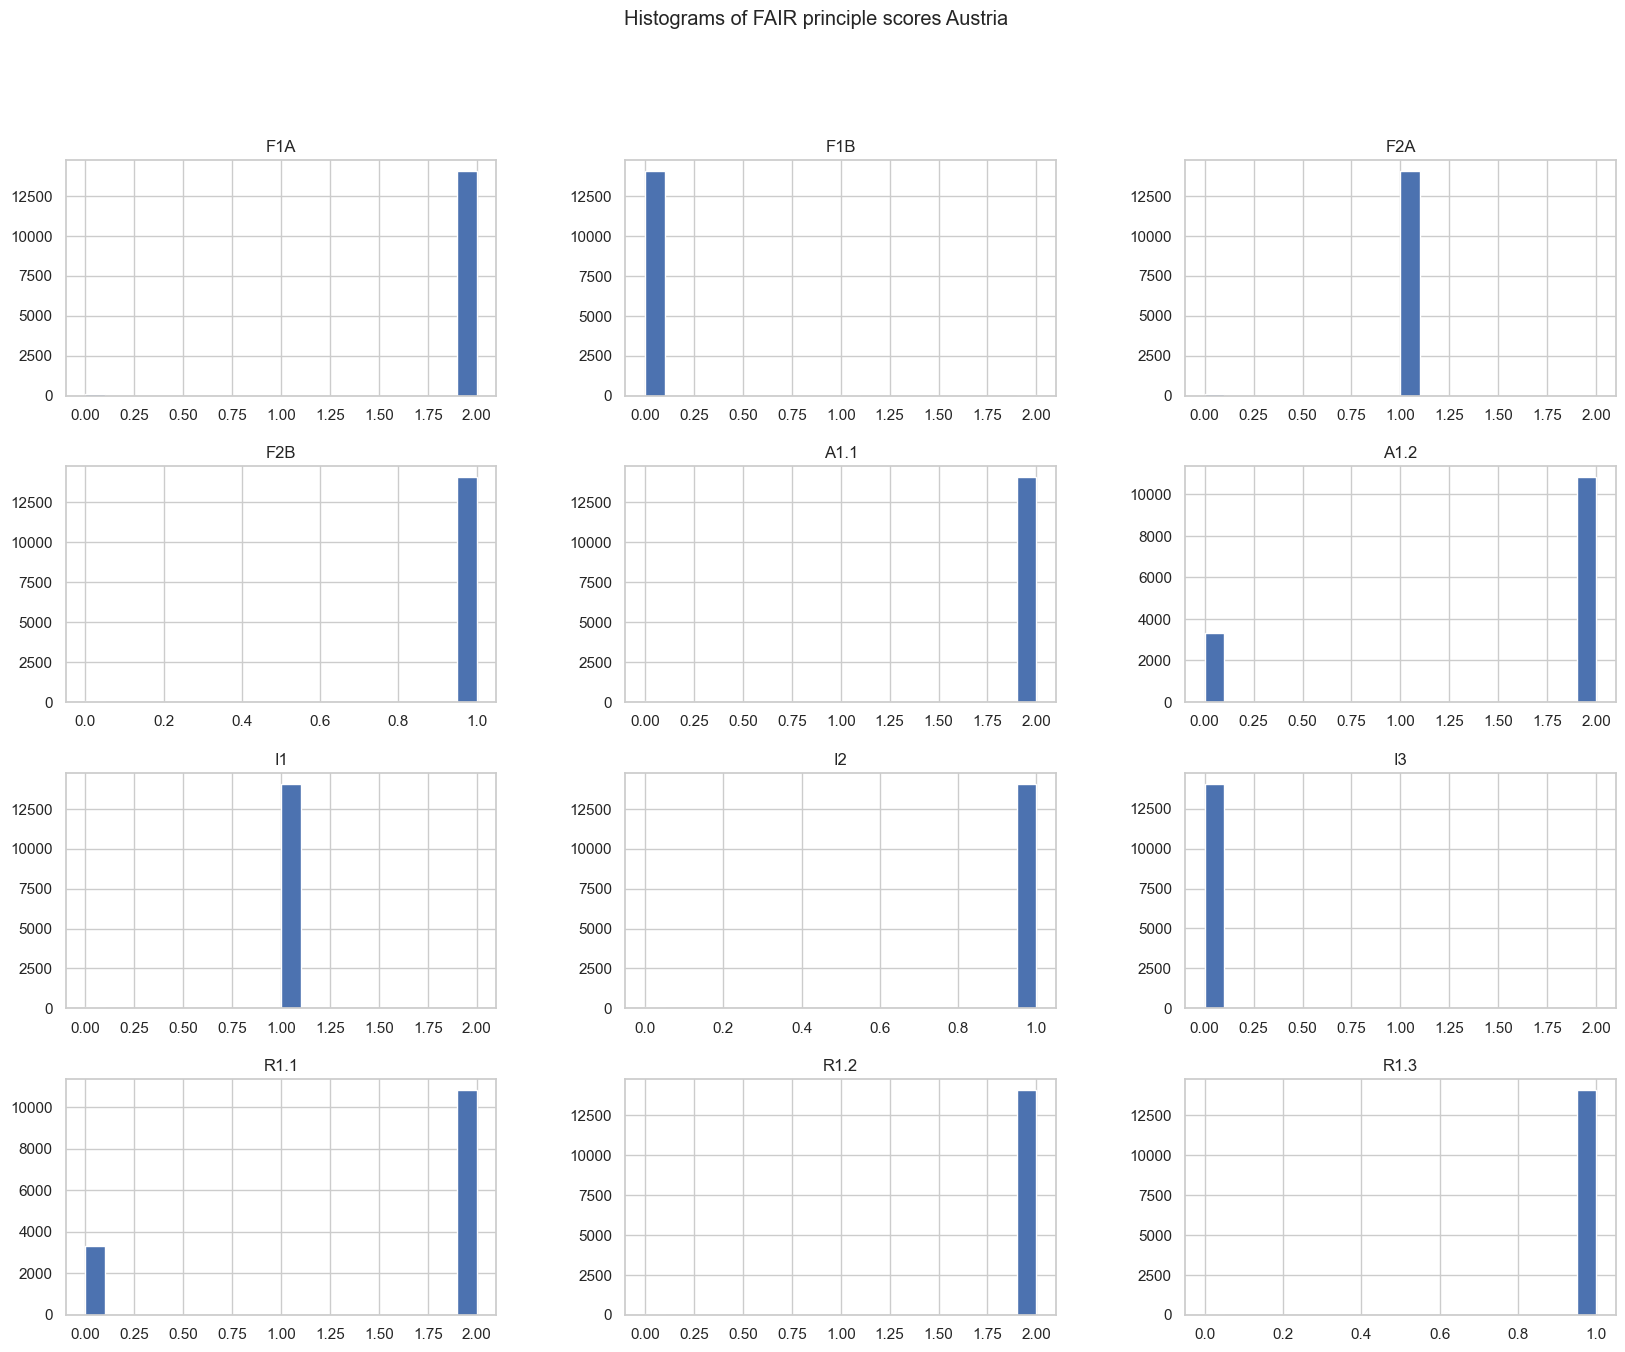

In [190]:
df[fair_metrics].hist(bins=20, figsize=(20, 15), layout=(4, 3))
plt.suptitle('Histograms of FAIR principle scores Austria')
plt.show()

In [195]:
for i in fair_metrics:
    display(combined_df[i].value_counts())

2    43200
0     3359
Name: F1A, dtype: int64

0    45617
2      933
1        9
Name: F1B, dtype: int64

1    28472
0    17503
2      584
Name: F2A, dtype: int64

1.0    25165
0.0    17516
2.0     3873
Name: F2B, dtype: int64

2.0    43311
0.0     3247
Name: A1.1, dtype: int64

0    33978
2    12581
Name: A1.2, dtype: int64

1    28462
0    17513
2      584
Name: I1, dtype: int64

1    25161
0    17519
2     3879
Name: I2, dtype: int64

0    44732
2     1827
Name: I3, dtype: int64

0    34245
2    12314
Name: R1.1, dtype: int64

0    31137
2    15422
Name: R1.2, dtype: int64

1    25164
0    17509
2     3886
Name: R1.3, dtype: int64

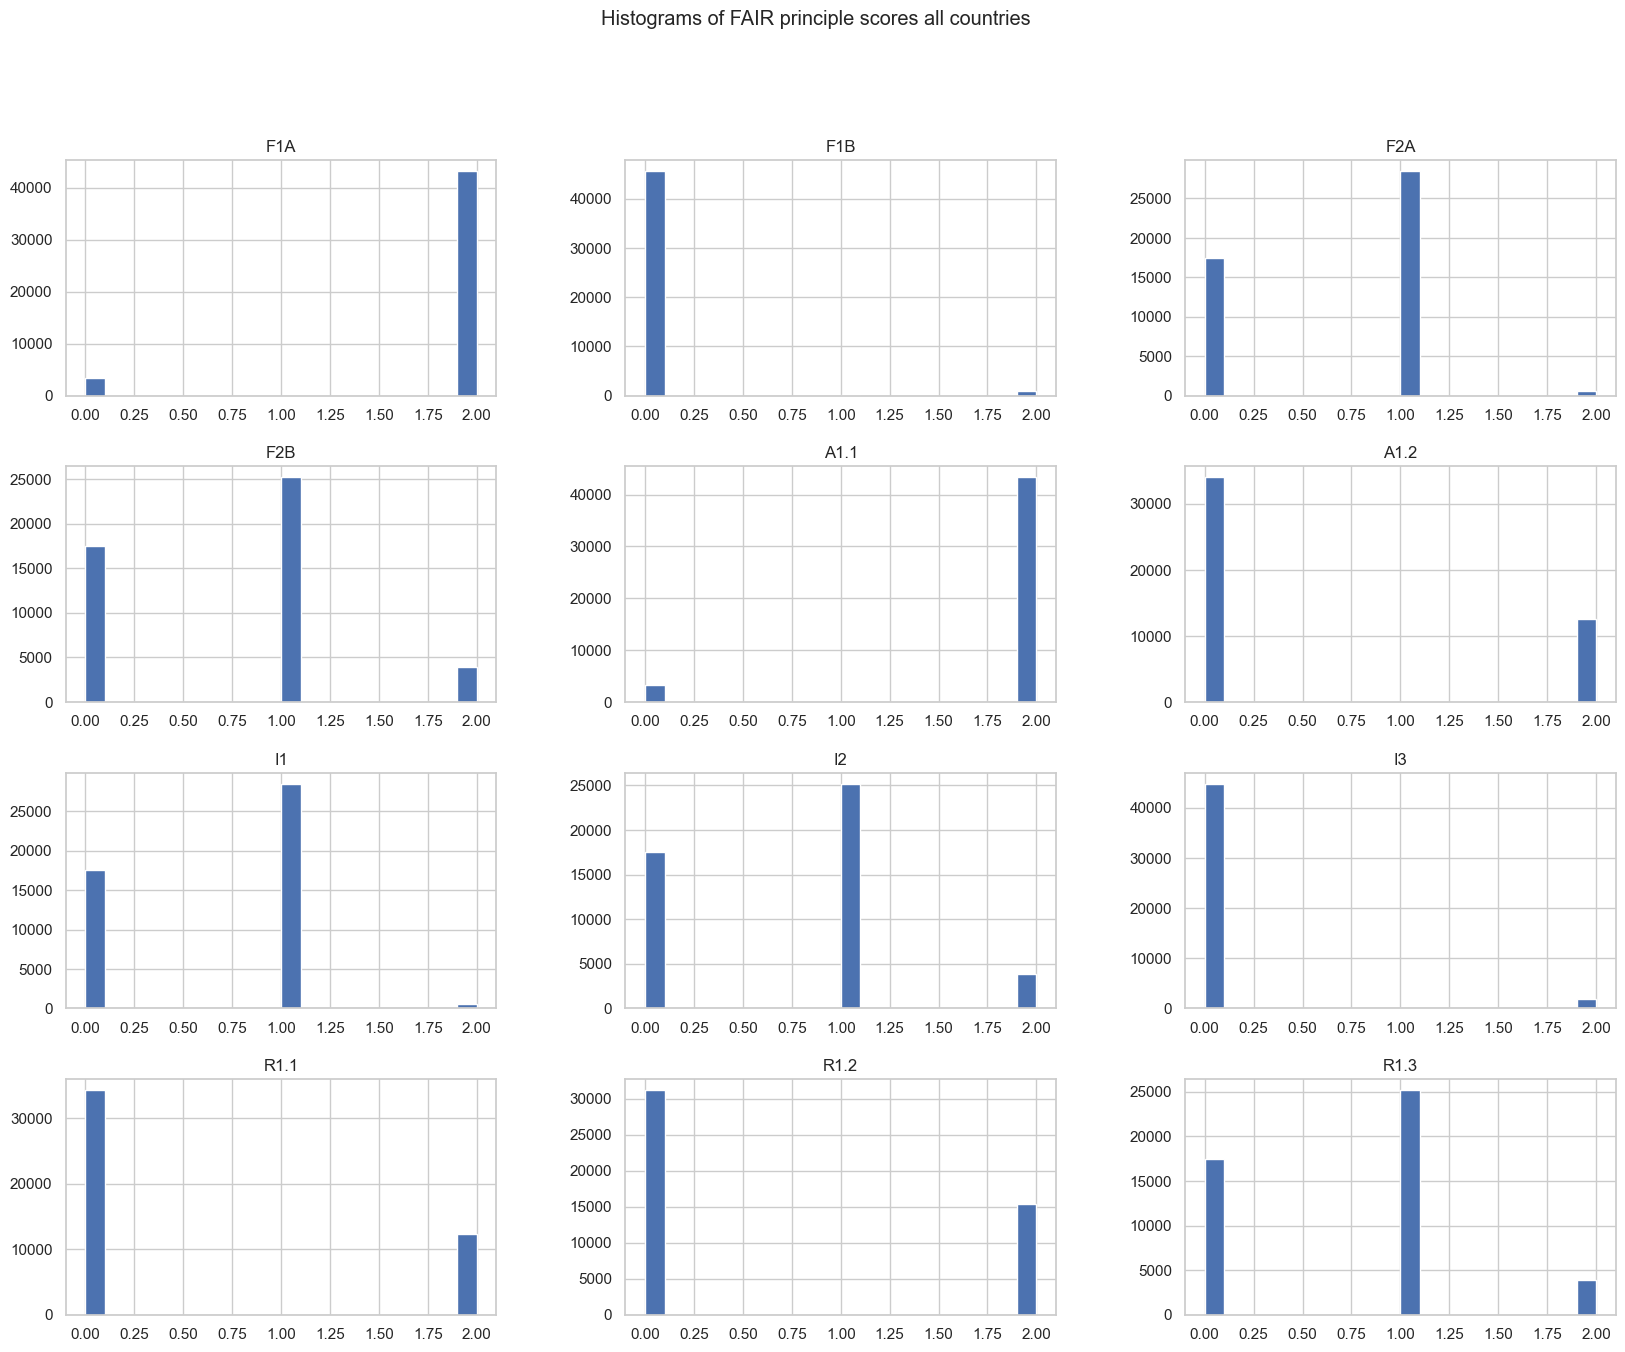

In [191]:
combined_df[fair_metrics].hist(bins=20, figsize=(20, 15), layout=(4, 3))
plt.suptitle('Histograms of FAIR principle scores all countries')
plt.show()

### Observations

- F1A(Unique IDs - FAIRChecker check that the resource identifier is an URL that can be reach, meaning it is unique, it is even better if the URL refer to a DOI) is the only principle that almost all datasets comply with - although its not surprising, as we used the URLs to perform the assessment

- F1B(Persistent IDs - Weak : FAIR-Checker verifies that at least one namespace from identifiers.org is used in metadata. Strong : FAIR-Checker verifies that the “identifier” property from DCTerms or Schema.org vocabularies is present in metadata.) and I3(External links - FAIR-Checker verifies that at least 3 different URL authorities are used in the URIs of RDF metadata.) principles on the other hand are basically never adhered